<a href="https://colab.research.google.com/github/francji1/01NAEX/blob/main/code/01NAEX_exercise_02_Python_student_solution01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 01NAEX - Exercise 02 (Python)
This notebook combines the lecture example (originally prepared in Python) with the student assignment that was previously distributed as an R notebook. The goal is to keep all analysis and exercises in one Python environment.



## Lecture Example - Plasma Etch Rate Experiment
The lecture example investigates how the plasma etch rate responds to the radio-frequency (RF) power setting and to potential run-to-run variation. We will:
- explore and visualise the raw data,
- fit ANOVA models with and without the run factor,
- inspect model diagnostics,
- perform multiple comparisons (Tukey HSD and Fisher's LSD), and
- evaluate design power for several sample sizes.


In [1]:
# Core scientific Python stack for the example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.graphics.gofplots import qqplot

sns.set_theme(style="whitegrid")
np.set_printoptions(suppress=True)


In [2]:
# Load the plasma etch rate data used in the lecture example
# Try local path first, fallback to GitHub URL
local_path = "/Users/michalprusek/PycharmProjects/01NAEX/data/etchrate.txt"
github_url = "https://raw.githubusercontent.com/francji1/01NAEX/refs/heads/main/data/etchrate.txt"

try:
    etch_rate = pd.read_csv(local_path, sep=r'\s+')
    print(f"✓ Data loaded from local: {local_path}")
except FileNotFoundError:
    etch_rate = pd.read_csv(github_url, sep=r'\s+')
    print(f"✓ Data loaded from GitHub: {github_url}")

# Create categorical views that will be useful for the formulas
etch_rate = etch_rate.assign(
    Power=etch_rate["RF"].astype("category"),
    Run=etch_rate["run"].astype("category")
)

print("Rows, columns:", etch_rate.shape)
display(etch_rate.head())
etch_rate.describe(include="all")

✓ Data loaded from GitHub: https://raw.githubusercontent.com/francji1/01NAEX/refs/heads/main/data/etchrate.txt
Rows, columns: (20, 5)


,RF,run,rate,Power,Run
0,160,1,575,160,1
1,160,2,542,160,2
2,160,3,530,160,3
3,160,4,539,160,4
4,160,5,570,160,5


,RF,run,rate,Power,Run
count,20.000000,20.000000,20.000000,20.0,20.0
unique,NaN,NaN,NaN,4.0,5.0
top,NaN,NaN,NaN,160.0,1.0
freq,NaN,NaN,NaN,5.0,4.0
mean,190.000000,3.000000,617.750000,NaN,NaN
std,22.941573,1.450953,61.648302,NaN,NaN
min,160.000000,1.000000,530.000000,NaN,NaN
25%,175.000000,2.000000,573.750000,NaN,NaN
50%,190.000000,3.000000,605.000000,NaN,NaN
75%,205.000000,4.000000,659.500000,NaN,NaN


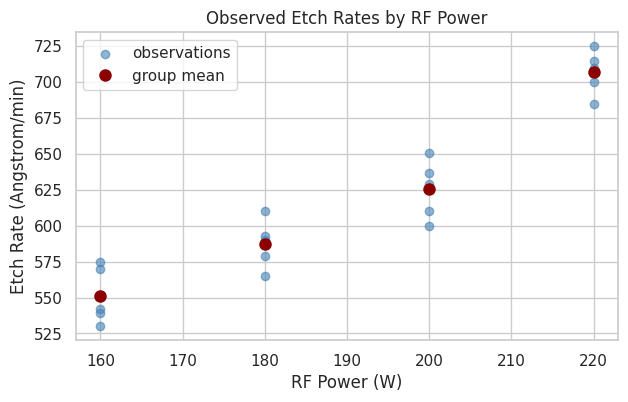

In [3]:
# Visual summary: scatter of observed rates with group means highlighted
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(etch_rate["RF"], etch_rate["rate"], color="steelblue", alpha=0.6, label="observations")
(
    etch_rate.groupby("RF")["rate"].mean()
    .plot(marker="o", color="darkred", linewidth=0, markersize=8, label="group mean", ax=ax)
)
ax.set_xlabel("RF Power (W)")
ax.set_ylabel("Etch Rate (Angstrom/min)")
ax.set_title("Observed Etch Rates by RF Power")
ax.legend()
plt.show()


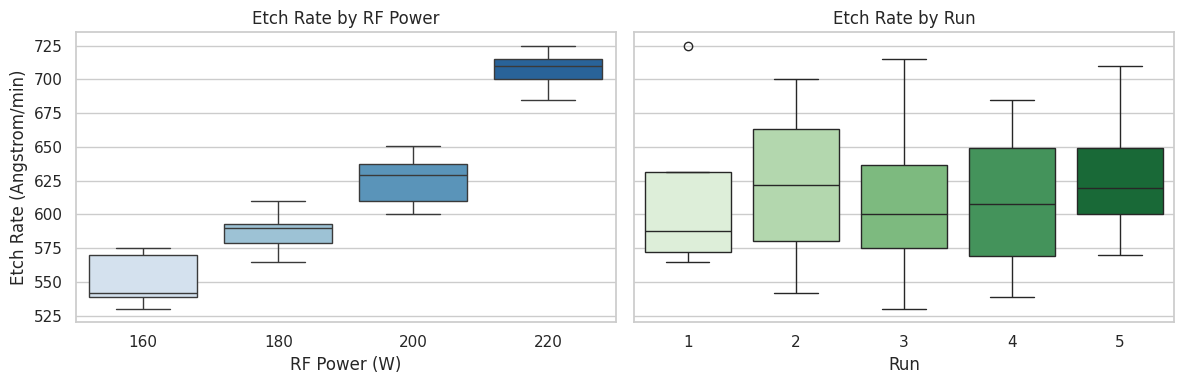

In [4]:
# Boxplots by RF power and by run to replicate the lecture visuals
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.boxplot(data=etch_rate, x="Power", y="rate", hue="Power", ax=axes[0], palette="Blues", legend=False)
axes[0].set_title("Etch Rate by RF Power")
axes[0].set_xlabel("RF Power (W)")
axes[0].set_ylabel("Etch Rate (Angstrom/min)")

sns.boxplot(data=etch_rate, x="Run", y="rate", hue="Run", ax=axes[1], palette="Greens", legend=False)
axes[1].set_title("Etch Rate by Run")
axes[1].set_xlabel("Run")

plt.tight_layout()
plt.show()

In [5]:
# Fit single-factor and two-factor ANOVA models used in the lecture
model_power = ols("rate ~ C(Power)", data=etch_rate).fit()
model_power_no_intercept = ols("rate ~ C(Power) - 1", data=etch_rate).fit()
model_power_run = ols("rate ~ C(Power) + C(Run)", data=etch_rate).fit()

print(model_power.summary())


                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     66.80
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           2.88e-09
Time:                        10:47:57   Log-Likelihood:                -84.250
No. Observations:                  20   AIC:                             176.5
Df Residuals:                      16   BIC:                             180.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         551.2000      8.169     

In [6]:
# ANOVA tables (type II sums of squares) for both models
anova_power = sm.stats.anova_lm(model_power, typ=2)
anova_power_run = sm.stats.anova_lm(model_power_run, typ=2)

display(anova_power)
display(anova_power_run)

# Direct comparison of the nested models (Power-only vs Power + Run)
display(sm.stats.anova_lm(model_power, model_power_run))


,sum_sq,df,F,PR(>F)
C(Power),66870.55,3.0,66.797073,2.882866e-09
Residual,5339.20,16.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(Power),66870.55,3.0,62.369063,1.368674e-07
C(Run),1050.50,4.0,0.734838,5.856737e-01
Residual,4288.70,12.0,NaN,NaN


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,16.0,5339.2,0.0,NaN,NaN,NaN
1,12.0,4288.7,4.0,1050.5,0.734838,0.585674


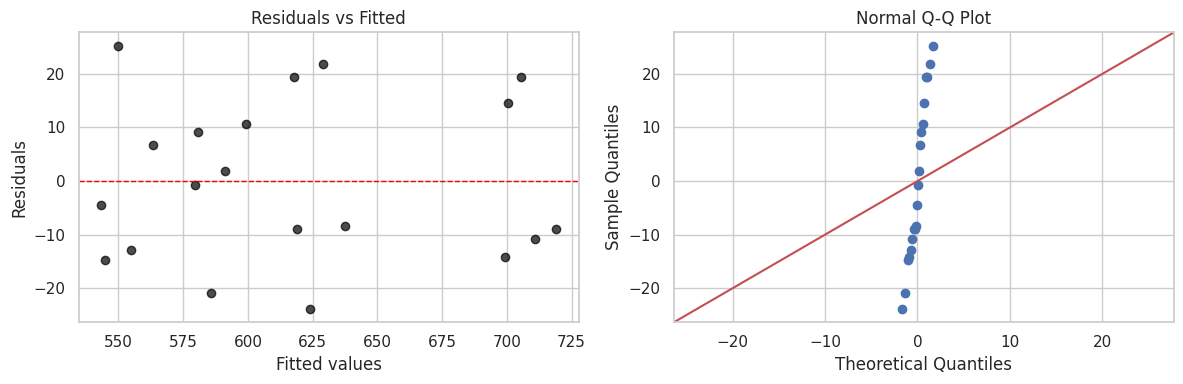

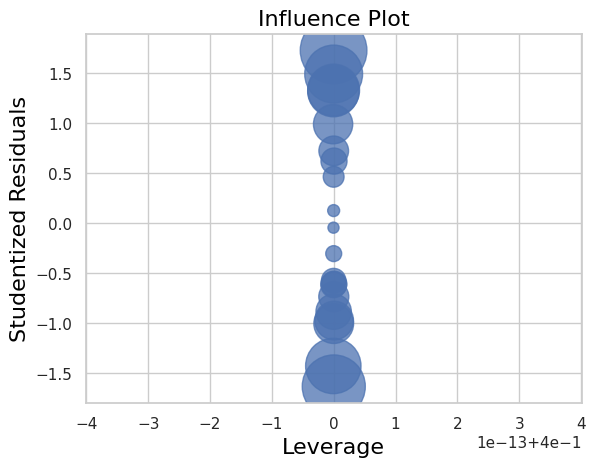

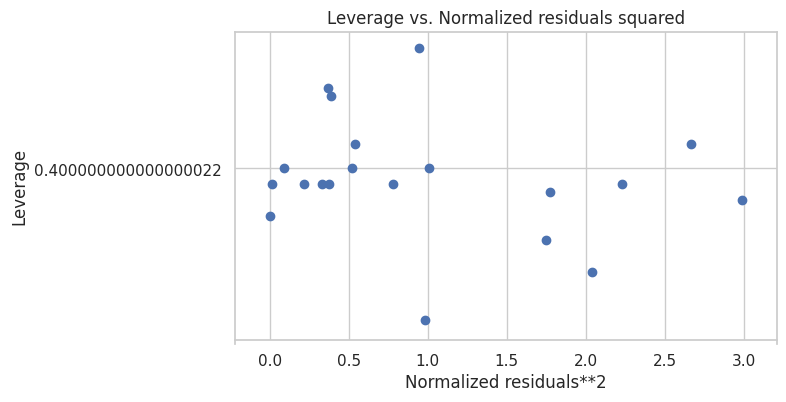

In [7]:
# Regression diagnostics mirroring the lecture content
residuals = model_power_run.resid
fitted = model_power_run.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(fitted, residuals, color="black", alpha=0.7)
axes[0].axhline(0, color="red", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

qqplot(residuals, line="45", ax=axes[1])
axes[1].set_title("Normal Q-Q Plot")

plt.tight_layout()
plt.show()

influence = OLSInfluence(model_power_run)
fig = influence.plot_influence(figsize=(8, 6))
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
sm.graphics.plot_leverage_resid2(model_power_run, ax=ax)
plt.show()


In [8]:
# Formal tests from the lecture (homogeneity, autocorrelation, etc.)
s_w, s_p = stats.shapiro(residuals)
levene_stat, levene_p = stats.levene(
    *[group["rate"].values for _, group in etch_rate.groupby("Power", observed=True)]
)
bartlett_stat, bartlett_p = stats.bartlett(
    *[group["rate"].values for _, group in etch_rate.groupby("Power", observed=True)]
)

bp_stat, bp_p, _, _ = het_breuschpagan(residuals, model_power_run.model.exog)
dw_stat = sm.stats.durbin_watson(residuals)

print(f"Shapiro-Wilk p-value: {s_p:.3f}")
print(f"Levene p-value:      {levene_p:.3f}")
print(f"Bartlett p-value:    {bartlett_p:.3f}")
print(f"Breusch-Pagan p:     {bp_p:.3f}")
print(f"Durbin-Watson stat:  {dw_stat:.3f}")


Shapiro-Wilk p-value: 0.317
Levene p-value:      0.898
Bartlett p-value:    0.443
Breusch-Pagan p:     0.038
Durbin-Watson stat:  2.854


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
   160    180     36.2 0.0294   3.1456  69.2544   True
   160    200     74.2    0.0  41.1456 107.2544   True
   160    220    155.8    0.0 122.7456 188.8544   True
   180    200     38.0 0.0216   4.9456  71.0544   True
   180    220    119.6    0.0  86.5456 152.6544   True
   200    220     81.6    0.0  48.5456 114.6544   True
------------------------------------------------------


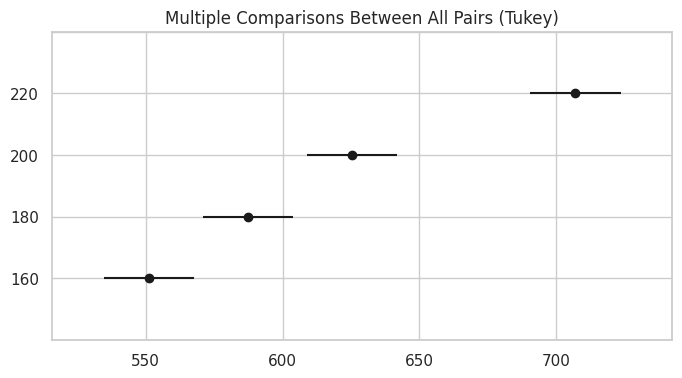

In [9]:
# Tukey HSD multiple comparisons (as demonstrated in the lecture)
tukey = pairwise_tukeyhsd(endog=etch_rate["rate"], groups=etch_rate["Power"], alpha=0.05)
print(tukey)
fig = tukey.plot_simultaneous(figsize=(8, 4))
plt.show()


In [10]:
# Fisher's LSD implementation with a compact letter display for quick interpretation
means = etch_rate.groupby("Power", observed=True)["rate"].mean()
counts = etch_rate.groupby("Power", observed=True)["rate"].count()
mse = anova_power_run.loc["Residual", "sum_sq"] / anova_power_run.loc["Residual", "df"]
df_error = anova_power_run.loc["Residual", "df"]

alpha = 0.05
t_crit = stats.t.ppf(1 - alpha / 2, df_error)
lsd = t_crit * np.sqrt(2 * mse / counts.mean())

print(f"Least Significant Difference (alpha={alpha}): {lsd:.2f}")
print("Group means (Angstrom/min):")
print(means.sort_index())

labels = {level: "" for level in means.index}
sorted_levels = means.sort_values(ascending=False).index

current_letter = ord("A")
for level in sorted_levels:
   if not labels[level]:
       labels[level] = chr(current_letter)
   for lower in sorted_levels[::-1]:
        if lower == level:
            continue
        diff = abs(means[level] - means[lower])
        if diff <= lsd:
            labels[lower] = labels[level]
        current_letter += 1

print("Compact letter display (shared letters indicate no significant difference):")
for level in sorted_levels:
        print(f"Power {level}: mean={means[level]:.1f}, label={labels[level]}")


Least Significant Difference (alpha=0.05): 26.05
Group means (Angstrom/min):
Power
160    551.2
180    587.4
200    625.4
220    707.0
Name: rate, dtype: float64
Compact letter display (shared letters indicate no significant difference):
Power 220: mean=707.0, label=A
Power 200: mean=625.4, label=D
Power 180: mean=587.4, label=G
Power 160: mean=551.2, label=J


,n per group,power
0,4,0.938481
1,5,0.991788
2,6,0.999172
3,7,0.999932
4,8,0.999995
5,9,1.000000
6,10,1.000000


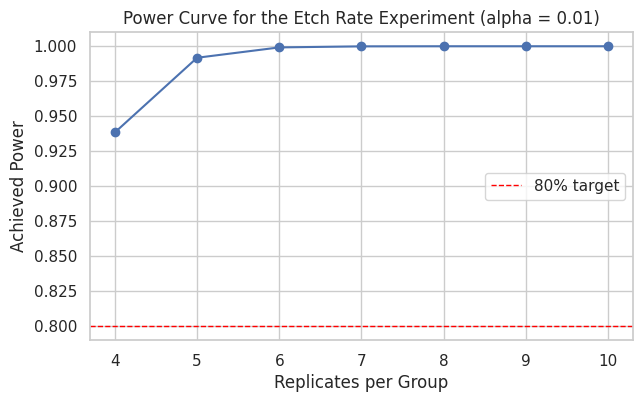

In [11]:
# Power exploration mirroring the lecture discussion
power_analysis = FTestAnovaPower()
alpha = 0.01
sigma = 25
max_diff = 75

cohen_f = (max_diff / 2) / sigma

sample_sizes = np.arange(4, 11)
power_values = [power_analysis.power(effect_size=cohen_f, nobs=n * 4, alpha=alpha, k_groups=4)
                for n in sample_sizes]

power_df = pd.DataFrame({"n per group": sample_sizes, "power": power_values})
display(power_df)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(sample_sizes, power_values, marker="o")
ax.set_xlabel("Replicates per Group")
ax.set_ylabel("Achieved Power")
ax.set_title("Power Curve for the Etch Rate Experiment (alpha = 0.01)")
ax.axhline(0.8, color="red", linestyle="--", linewidth=1, label="80% target")
ax.legend()
plt.show()



## Student Assignment - Chapter 3 Exercises
Use the following cells to work through the problems. Each question mirrors the wording from the textbook; add your analysis in the empty code cells provided.



### Exercise 3.07 - Portland Cement Tensile Strength
Four mixing techniques are compared using a completely randomised design; tensile strength (lb/in^2) is recorded for four replicates at each technique.


In [35]:
# Data for Exercise 3.07
# Try local path first, fallback to GitHub URL
local_path = "/Users/"
github_url = "https://raw.githubusercontent.com/francji1/01NAEX/main/data/Ex03_7.csv"

try:
    ex03_7 = pd.read_csv(local_path, sep=";")
    print(f"✓ Data loaded from local: {local_path}")
except FileNotFoundError:
    ex03_7 = pd.read_csv(github_url, sep=";")
    print(f"✓ Data loaded from GitHub: {github_url}")

ex03_7 = ex03_7.assign(Technique=ex03_7["Technique"].astype("category"))
cement = ex03_7.rename(columns={"Tensile_Strength": "strength"})
cement.head()

✓ Data loaded from GitHub: https://raw.githubusercontent.com/francji1/01NAEX/main/data/Ex03_7.csv


,Technique,strength
0,1,3129
1,1,3000
2,1,2865
3,1,2890
4,2,3200


**Question 1.** Construct graphical displays that compare the mean tensile strengths for the four mixing techniques.

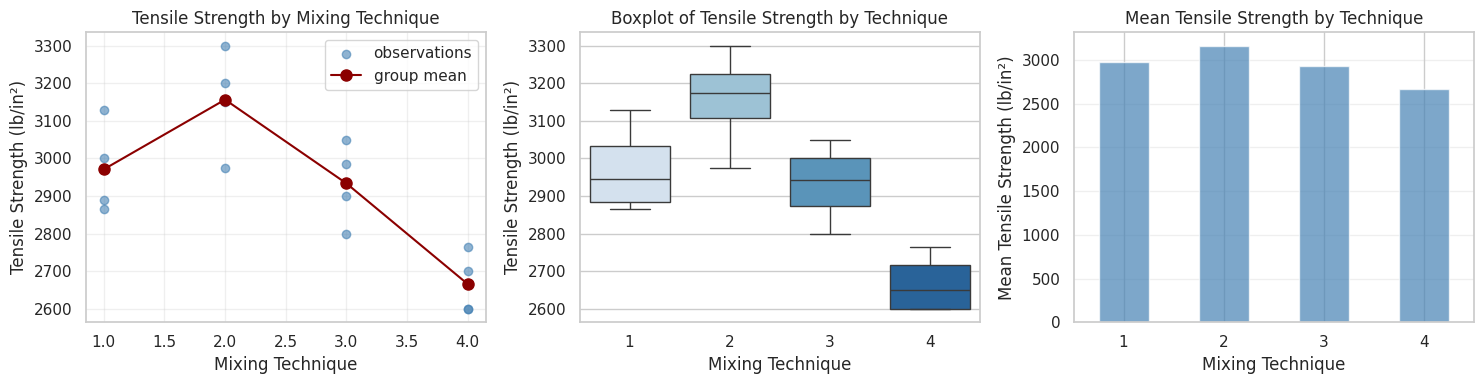

Summary statistics by technique:
           count     mean         std     min      25%     50%      75%  \
Technique                                                                 
1            4.0  2971.00  120.557040  2865.0  2883.75  2945.0  3032.25   
2            4.0  3156.25  135.976407  2975.0  3106.25  3175.0  3225.00   
3            4.0  2933.75  108.272419  2800.0  2875.00  2942.5  3001.25   
4            4.0  2666.25   80.970674  2600.0  2600.00  2650.0  2716.25   

              max  
Technique          
1          3129.0  
2          3300.0  
3          3050.0  
4          2765.0  


In [13]:
# Question 1: Graphical displays comparing mean tensile strengths
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Scatter plot with group means
axes[0].scatter(cement["Technique"], cement["strength"], color="steelblue", alpha=0.6, label="observations")
cement_means = cement.groupby("Technique", observed=True)["strength"].mean()
axes[0].plot(cement_means.index, cement_means.values, 'o-', color="darkred", markersize=8, label="group mean")
axes[0].set_xlabel("Mixing Technique")
axes[0].set_ylabel("Tensile Strength (lb/in²)")
axes[0].set_title("Tensile Strength by Mixing Technique")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
sns.boxplot(data=cement, x="Technique", y="strength", hue="Technique", ax=axes[1], palette="Blues", legend=False)
axes[1].set_title("Boxplot of Tensile Strength by Technique")
axes[1].set_xlabel("Mixing Technique")
axes[1].set_ylabel("Tensile Strength (lb/in²)")

# Bar plot with means
cement_means.plot(kind='bar', ax=axes[2], color='steelblue', alpha=0.7)
axes[2].set_title("Mean Tensile Strength by Technique")
axes[2].set_xlabel("Mixing Technique")
axes[2].set_ylabel("Mean Tensile Strength (lb/in²)")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Summary statistics by technique:")
print(cement.groupby("Technique", observed=True)["strength"].describe())

# Pouze základní přehled. Pravděpodobně tam bude rozdíl ve středních hodnotách pevnosti v tahu napříč technikami.

**Question 2.** Test at alpha = 0.05 whether mixing technique affects tensile strength.

In [14]:
# Question 2: Test at alpha = 0.05 whether mixing technique affects tensile strength
# Fit ANOVA model
model_cement = ols("strength ~ C(Technique)", data=cement).fit()
anova_cement = sm.stats.anova_lm(model_cement, typ=2)

print("ANOVA Table:")
print(anova_cement)
print("\n" + "="*60)

# Extract key statistics
f_stat = anova_cement.loc["C(Technique)", "F"]
p_value = anova_cement.loc["C(Technique)", "PR(>F)"]
alpha = 0.05

print(f"\nF-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significance level α: {alpha}")
print("\n" + "="*60)

if p_value < alpha:
    print(f"\nConclusion: Since p-value ({p_value:.6f}) < α ({alpha}),")
    print("we REJECT H₀ at the 0.05 significance level.")
    print("There IS a statistically significant difference in tensile strength")
    print("due to mixing technique.")
else:
    print(f"\nConclusion: Since p-value ({p_value:.6f}) ≥ α ({alpha}),")
    print("we FAIL TO REJECT H₀ at the 0.05 significance level.")
    print("There is NO statistically significant difference in tensile strength")
    print("due to mixing technique.")

print("\n" + "="*60)
print("\nModel Summary:")
print(model_cement.summary())

ANOVA Table:
                   sum_sq    df          F    PR(>F)
C(Technique)  489740.1875   3.0  12.728107  0.000489
Residual      153908.2500  12.0        NaN       NaN


F-statistic: 12.7281
P-value: 0.000489
Significance level α: 0.05


Conclusion: Since p-value (0.000489) < α (0.05),
we REJECT H₀ at the 0.05 significance level.
There IS a statistically significant difference in tensile strength
due to mixing technique.


Model Summary:
                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     12.73
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           0.000489
Time:                        10:48:01   Log-Likelihood:                -96.075
No. Observations:                  16   AIC:                             200.2
D

# Alespoň jeden pár technik má statisticky významný rozdíl ve střední hodnotě pevnosti v tahu.

**Question 3.** Use Fisher's LSD method with alpha = 0.05 to make pairwise comparisons between techniques.

In [15]:
# Question 3: Fisher's LSD method with alpha = 0.05 for pairwise comparisons
alpha = 0.05
means = cement.groupby("Technique", observed=True)["strength"].mean()
counts = cement.groupby("Technique", observed=True)["strength"].count()
mse = anova_cement.loc["Residual", "sum_sq"] / anova_cement.loc["Residual", "df"]
df_error = int(anova_cement.loc["Residual", "df"])

# Calculate LSD
t_crit = stats.t.ppf(1 - alpha / 2, df_error)
lsd = t_crit * np.sqrt(2 * mse / counts.mean())

print("Fisher's Least Significant Difference (LSD) Method")
print("="*60)
print(f"Alpha: {alpha}")
print(f"MSE: {mse:.4f}")
print(f"Degrees of freedom (error): {df_error}")
print(f"Critical t-value: {t_crit:.4f}")
print(f"LSD = {lsd:.4f}")
print("\n" + "="*60)

print("\nGroup Means (sorted):")
means_sorted = means.sort_values(ascending=False)
for tech, mean_val in means_sorted.items():
    print(f"Technique {tech}: {mean_val:.2f} lb/in²")

print("\n" + "="*60)
print("\nPairwise Comparisons:")
print(f"(Two means differ significantly if |difference| > LSD = {lsd:.4f})")
print("\n")

# Perform all pairwise comparisons
techniques = means_sorted.index.tolist()
significant_pairs = []
for i in range(len(techniques)):
    for j in range(i+1, len(techniques)):
        tech1, tech2 = techniques[i], techniques[j]
        diff = abs(means[tech1] - means[tech2])
        is_sig = diff > lsd
        sig_marker = "***" if is_sig else "n.s."
        print(f"Technique {tech1} vs {tech2}: |{means[tech1]:.2f} - {means[tech2]:.2f}| = {diff:.4f} {sig_marker}")
        if is_sig:
            significant_pairs.append((tech1, tech2))

print("\n" + "="*60)
print(f"\nSignificant differences (at α = {alpha}):")
if significant_pairs:
    for tech1, tech2 in significant_pairs:
        print(f"  • Technique {tech1} ≠ Technique {tech2}")
else:
    print("  No significant pairwise differences found.")

Fisher's Least Significant Difference (LSD) Method
Alpha: 0.05
MSE: 12825.6875
Degrees of freedom (error): 12
Critical t-value: 2.1788
LSD = 174.4798


Group Means (sorted):
Technique 2: 3156.25 lb/in²
Technique 1: 2971.00 lb/in²
Technique 3: 2933.75 lb/in²
Technique 4: 2666.25 lb/in²


Pairwise Comparisons:
(Two means differ significantly if |difference| > LSD = 174.4798)


Technique 2 vs 1: |3156.25 - 2971.00| = 185.2500 ***
Technique 2 vs 3: |3156.25 - 2933.75| = 222.5000 ***
Technique 2 vs 4: |3156.25 - 2666.25| = 490.0000 ***
Technique 1 vs 3: |2971.00 - 2933.75| = 37.2500 n.s.
Technique 1 vs 4: |2971.00 - 2666.25| = 304.7500 ***
Technique 3 vs 4: |2933.75 - 2666.25| = 267.5000 ***


Significant differences (at α = 0.05):
  • Technique 2 ≠ Technique 1
  • Technique 2 ≠ Technique 3
  • Technique 2 ≠ Technique 4
  • Technique 1 ≠ Technique 4
  • Technique 3 ≠ Technique 4


 # Mezi všemi technikami jsou statisticky významné rozdíly ve středních hodnotách pevnosti v tahu, kromě technik 1 a 4.


**Question 4.** Construct a normal probability plot of the residuals. Does the normality assumption appear reasonable?

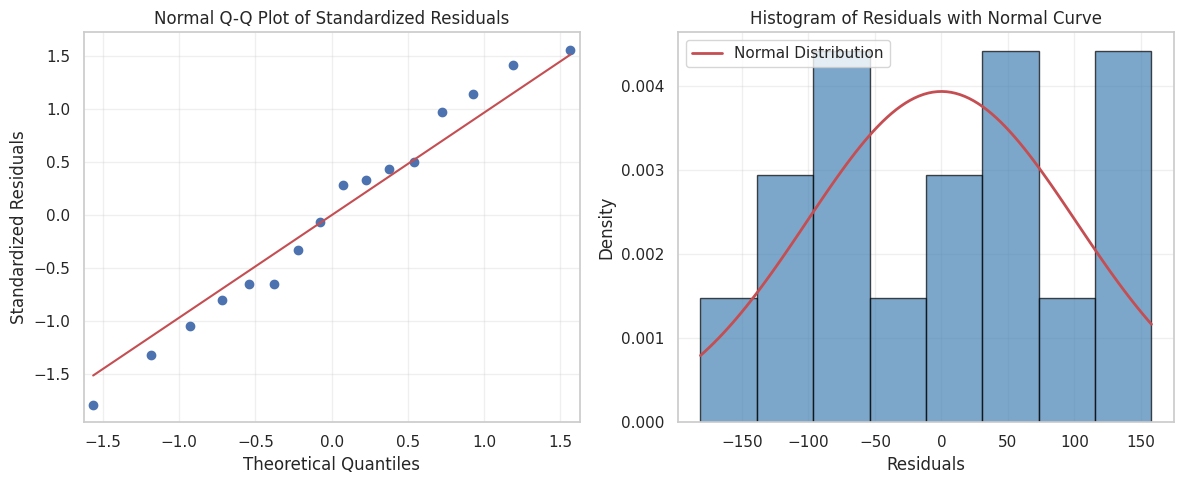

Normality Assessment
Shapiro-Wilk Test:
  W-statistic: 0.9705
  P-value: 0.8460


Conclusion: Since p-value (0.8460) > 0.05,
we FAIL TO REJECT the null hypothesis of normality.
The normality assumption appears REASONABLE.

Interpretation of Q-Q plot:
If points roughly follow the 45° line, normality is reasonable.
Standardized residuals should fall mostly within ±2 for normal data.


In [16]:
# Question 4: Normal probability plot of residuals
residuals_cement = model_cement.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot with standardized residuals
standardized_resid = (residuals_cement - residuals_cement.mean()) / residuals_cement.std()
qqplot(standardized_resid, line="s", ax=axes[0])
axes[0].set_title("Normal Q-Q Plot of Standardized Residuals", fontsize=12)
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Standardized Residuals")
axes[0].grid(True, alpha=0.3)

# Histogram with normal curve overlay
axes[1].hist(residuals_cement, bins=8, density=True, alpha=0.7, color='steelblue', edgecolor='black')
mu, sigma = residuals_cement.mean(), residuals_cement.std()
x = np.linspace(residuals_cement.min(), residuals_cement.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
axes[1].set_title("Histogram of Residuals with Normal Curve", fontsize=12)
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(residuals_cement)

print("Normality Assessment")
print("="*60)
print(f"Shapiro-Wilk Test:")
print(f"  W-statistic: {shapiro_stat:.4f}")
print(f"  P-value: {shapiro_p:.4f}")
print("\n" + "="*60)

if shapiro_p > 0.05:
    print(f"\nConclusion: Since p-value ({shapiro_p:.4f}) > 0.05,")
    print("we FAIL TO REJECT the null hypothesis of normality.")
    print("The normality assumption appears REASONABLE.")
else:
    print(f"\nConclusion: Since p-value ({shapiro_p:.4f}) ≤ 0.05,")
    print("we REJECT the null hypothesis of normality.")
    print("The normality assumption may be QUESTIONABLE.")

print("\nInterpretation of Q-Q plot:")
print("If points roughly follow the 45° line, normality is reasonable.")
print("Standardized residuals should fall mostly within ±2 for normal data.")

# QQ plot vypadá moc hezky. U histogramu reziduí bych si netipl, že residua budou rozdělena normálně. Normalitu ale nezamítá podle Shapiro-Wilka (roli hraje i to, že máme málo dat)

**Question 5.** Plot the residuals versus the fitted tensile strength and comment.

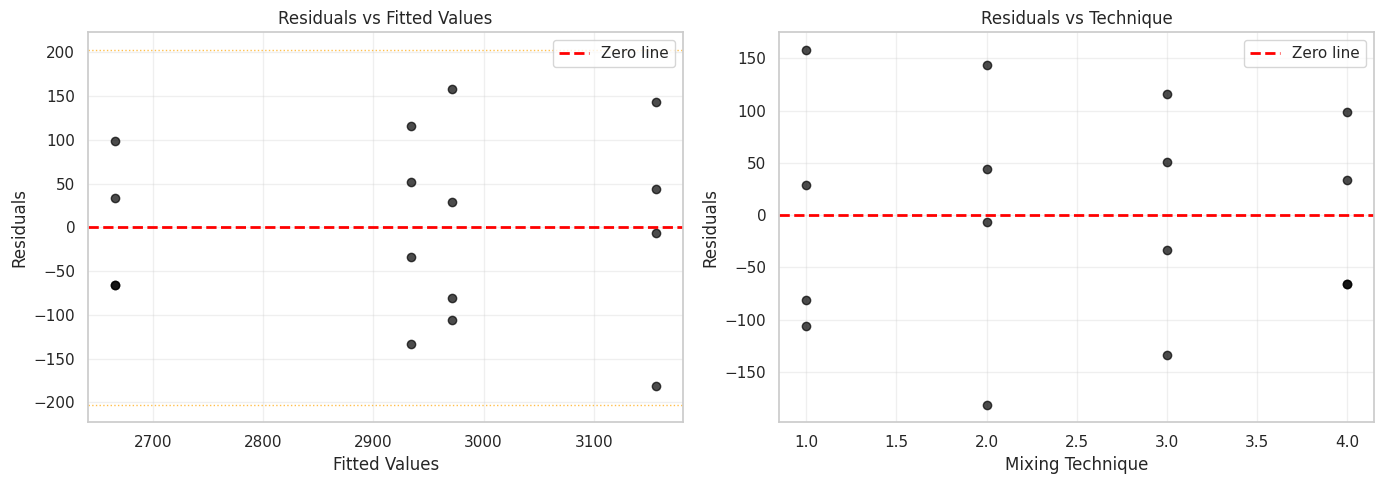

Residuals vs Fitted Values - Diagnostic Assessment

What to look for:
  • Random scatter around zero line → Good (constant variance)
  • Funnel/trumpet shape → Heteroscedasticity
  • Curved pattern → Non-linearity or missing terms
  • Outliers → Points far from ±2 standard deviations


Levene's Test for Homogeneity of Variance:
  Test statistic: 0.1833
  P-value: 0.9057

  Conclusion: p-value (0.9057) > 0.05
  → Fail to reject H₀: Variances appear equal (homoscedasticity)


In [17]:
# Question 5: Plot residuals vs fitted values
fitted_cement = model_cement.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Fitted
axes[0].scatter(fitted_cement, residuals_cement, color='black', alpha=0.7)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add horizontal reference lines at ±2*std
std_res = residuals_cement.std()
axes[0].axhline(2*std_res, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0].axhline(-2*std_res, color='orange', linestyle=':', linewidth=1, alpha=0.7)

# Residuals vs Factor Level
axes[1].scatter(cement["Technique"], residuals_cement, color='black', alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[1].set_xlabel("Mixing Technique")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs Technique")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Residuals vs Fitted Values - Diagnostic Assessment")
print("="*60)
print("\nWhat to look for:")
print("  • Random scatter around zero line → Good (constant variance)")
print("  • Funnel/trumpet shape → Heteroscedasticity")
print("  • Curved pattern → Non-linearity or missing terms")
print("  • Outliers → Points far from ±2 standard deviations")
print("\n" + "="*60)

# Levene's test for homogeneity of variance
levene_stat, levene_p = stats.levene(
    *[group["strength"].values for _, group in cement.groupby("Technique", observed=True)]
)

print(f"\nLevene's Test for Homogeneity of Variance:")
print(f"  Test statistic: {levene_stat:.4f}")
print(f"  P-value: {levene_p:.4f}")

if levene_p > 0.05:
    print(f"\n  Conclusion: p-value ({levene_p:.4f}) > 0.05")
    print("  → Fail to reject H₀: Variances appear equal (homoscedasticity)")
else:
    print(f"\n  Conclusion: p-value ({levene_p:.4f}) ≤ 0.05")
    print("  → Reject H₀: Variances may not be equal (heteroscedasticity)")

# Ještě udělám standardizovaná rezidua. Tady to dává smysl - jsou normálně rozdělena. Očekáváme všechna v pásu -2 a 2 - podle pravidla dvou sigma by v tomto pásu mělo být asi 95% reziduí (za předpokladu normality). Jsou navíc homogenně rozložené v tomto pásu - podle Levene testu nezamítáme homoskedascicitu.

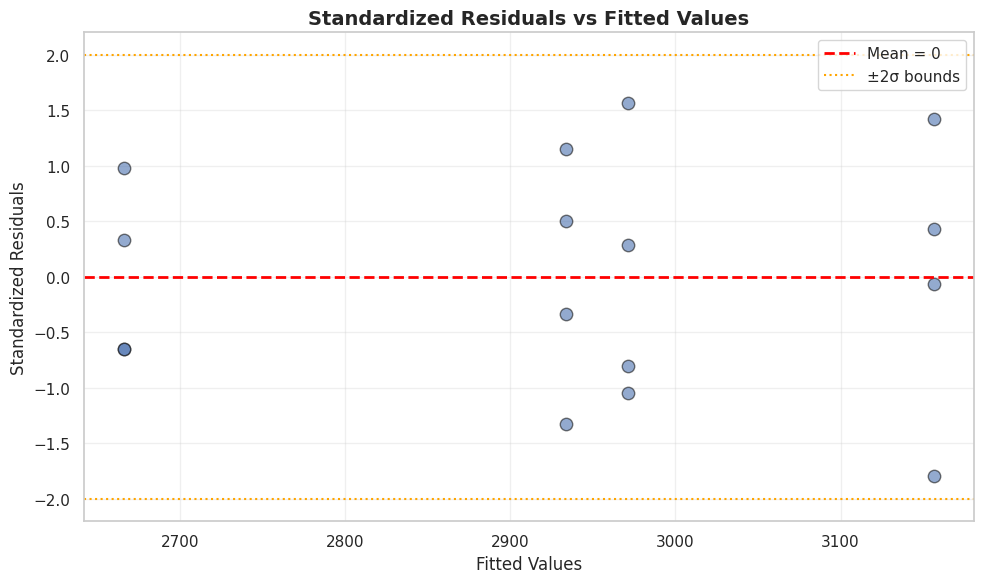


Standardized residuals within ±2σ: 16/16 (100.0%)


In [18]:
# Standardized residuals plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Calculate standardized residuals
standardized_resid_cement = (residuals_cement - residuals_cement.mean()) / residuals_cement.std()
fitted_cement = model_cement.fittedvalues

# Plot standardized residuals vs fitted values
ax.scatter(fitted_cement, standardized_resid_cement, alpha=0.6, edgecolors='k', s=80)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
ax.axhline(y=2, color='orange', linestyle=':', linewidth=1.5, label='±2σ bounds')
ax.axhline(y=-2, color='orange', linestyle=':', linewidth=1.5)
ax.set_xlabel('Fitted Values', fontsize=12)
ax.set_ylabel('Standardized Residuals', fontsize=12)
ax.set_title('Standardized Residuals vs Fitted Values', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Count residuals within ±2σ
within_2sigma = np.sum(np.abs(standardized_resid_cement) <= 2)
total = len(standardized_resid_cement)
percentage = (within_2sigma / total) * 100

print(f"\nStandardized residuals within ±2σ: {within_2sigma}/{total} ({percentage:.1f}%)")

# Perfektní

**Question 6.** Prepare a scatter plot of the raw observations to aid interpretation.

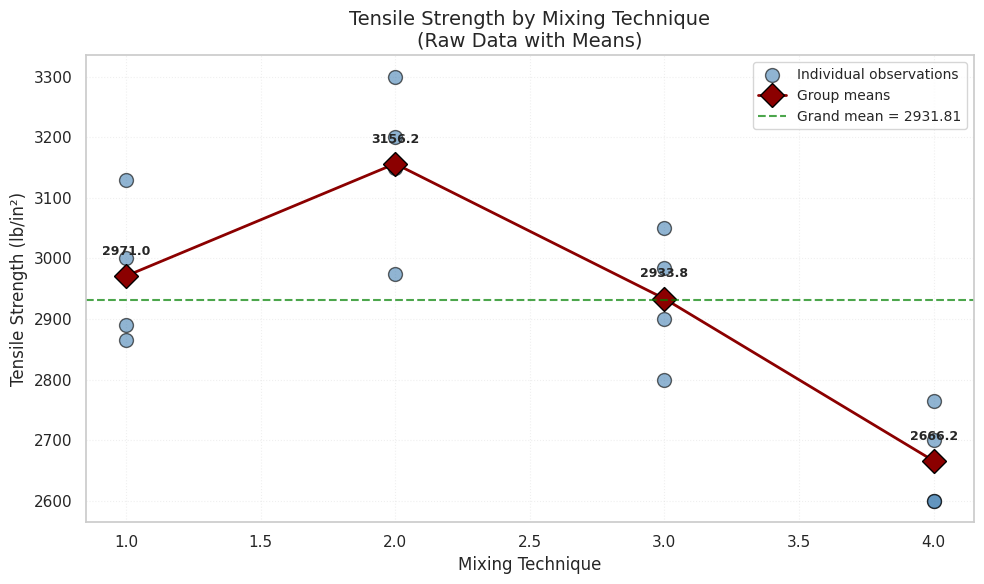

Interpretation Aid:
This scatter plot shows:
  • Individual observations (blue circles)
  • Group means (red diamonds connected by line)
  • Grand mean (green dashed line)
  • Variation within each technique
  • Differences between technique means

Look for:
  • Separation between groups → technique effect
  • Overlap within groups → random variation


In [19]:
# Question 6: Scatter plot of raw observations
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of raw data
ax.scatter(cement["Technique"], cement["strength"],
           s=100, alpha=0.6, color="steelblue", edgecolors='black', linewidth=1,
           label="Individual observations")

# Overlay group means with larger markers
cement_means = cement.groupby("Technique", observed=True)["strength"].mean()
ax.plot(cement_means.index, cement_means.values,
        'D-', color="darkred", markersize=12, linewidth=2,
        label="Group means", markeredgecolor='black', markeredgewidth=1)

# Add horizontal line at grand mean
grand_mean = cement["strength"].mean()
ax.axhline(grand_mean, color='green', linestyle='--', linewidth=1.5,
           alpha=0.7, label=f'Grand mean = {grand_mean:.2f}')

ax.set_xlabel("Mixing Technique", fontsize=12)
ax.set_ylabel("Tensile Strength (lb/in²)", fontsize=12)
ax.set_title("Tensile Strength by Mixing Technique\n(Raw Data with Means)", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)

# Add value annotations for means
for tech, mean_val in cement_means.items():
    ax.text(tech, mean_val + 30, f'{mean_val:.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("Interpretation Aid:")
print("="*60)
print("This scatter plot shows:")
print("  • Individual observations (blue circles)")
print("  • Group means (red diamonds connected by line)")
print("  • Grand mean (green dashed line)")
print("  • Variation within each technique")
print("  • Differences between technique means")
print("\nLook for:")
print("  • Separation between groups → technique effect")
print("  • Overlap within groups → random variation")


### Exercises 3.08 and 3.09 - Follow-Up Comparisons
We revisit the Portland cement experiment to explore multiple comparisons and confidence intervals.


**Question 1.** Rework the pairwise comparisons using Tukey's test with alpha = 0.05. Do the conclusions match the graphical procedure and Fisher's LSD?

Tukey's Honestly Significant Difference (HSD) Test
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2 meandiff p-adj    lower     upper   reject
--------------------------------------------------------
     1      2   185.25 0.1494  -52.5003  423.0003  False
     1      3   -37.25 0.9653 -275.0003  200.5003  False
     1      4  -304.75 0.0116 -542.5003  -66.9997   True
     2      3   -222.5 0.0693 -460.2503   15.2503  False
     2      4   -490.0 0.0003 -727.7503 -252.2497   True
     3      4   -267.5 0.0262 -505.2503  -29.7497   True
--------------------------------------------------------



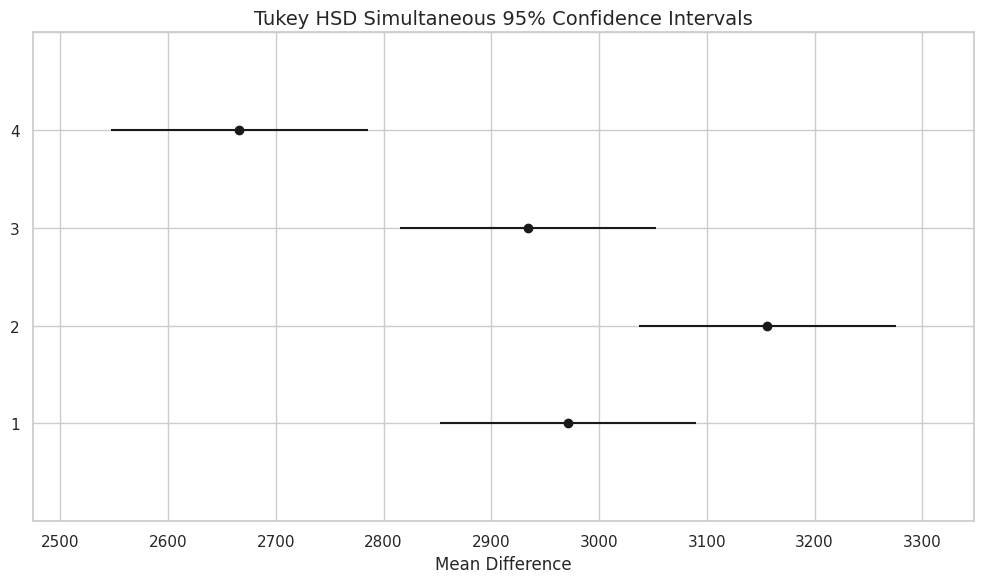

In [20]:
# Question 1: Tukey's test with alpha = 0.05
alpha = 0.05

# Tukey HSD test
tukey_cement = pairwise_tukeyhsd(endog=cement["strength"],
                                  groups=cement["Technique"],
                                  alpha=alpha)

print("Tukey's Honestly Significant Difference (HSD) Test")
print("="*60)
print(tukey_cement)
print("\n" + "="*60)

# Plot Tukey HSD results
fig = tukey_cement.plot_simultaneous(figsize=(10, 6))
plt.title("Tukey HSD Simultaneous 95% Confidence Intervals", fontsize=14)
plt.xlabel("Mean Difference", fontsize=12)
plt.tight_layout()
plt.show()

# Tukey HSD identifikoval statisticky významný rozdíl už pouze u párů technik 1 a 4, 2 a 4, 3 a 4. Tukey HSD je přísnější než Fisherův LSD, lépe chrání proti chybě prvního druhu při mnohonásobném porovnávání a tím snižuje pravděpodobnost falešně pozitivních výsledků.


**Question 2.** Explain the difference between Tukey's procedure and Fisher's LSD.


**Difference between Tukey's procedure and Fisher's LSD:**

**Tukey's HSD (Honestly Significant Difference):**
- **Purpose:** Controls the family-wise error rate (FWER) across all pairwise comparisons
- **Method:** Uses the studentized range distribution (q-statistic)
- **Conservative:** More strict, reduces Type I errors when comparing multiple pairs
- **When to use:** All pairwise comparisons after ANOVA, especially with many groups
- **Formula:** Uses critical value from studentized range: HSD = q_α √(MSE/n)

**Fisher's LSD (Least Significant Difference):**
- **Purpose:** Tests individual pairwise comparisons using t-distribution
- **Method:** Uses pairwise t-tests with pooled variance (MSE)
- **Liberal:** More powerful but does NOT properly control FWER
- **When to use:** Limited comparisons, or when ANOVA F-test is significant (protected LSD)
- **Formula:** Uses critical t-value: LSD = t_α/2 √(2·MSE/n)

**Key difference:** Tukey's method accounts for multiple testing by using a larger critical value (from q-distribution), making it harder to declare significance. Fisher's LSD treats each comparison independently, leading to inflated Type I error rate when many comparisons are made.

**Trade-off:** Tukey is safer (controls FWER) but less powerful; Fisher's LSD is more powerful but riskier with multiple tests.

**Question 3.** Find 95 percent confidence intervals for each technique mean and for the difference between techniques 1 and 3. How do these intervals aid interpretation?

In [21]:
# Question 3: 95% confidence intervals for each technique mean and difference between techniques 1 and 3

# CI for individual means
alpha = 0.05
t_crit_ci = stats.t.ppf(1 - alpha/2, df_error)
n_per_group = cement.groupby("Technique", observed=True)["strength"].count().iloc[0]
se_mean = np.sqrt(mse / n_per_group)

print("95% Confidence Intervals for Individual Technique Means")
print("="*60)
print(f"Standard error of mean: √(MSE/n) = √({mse:.2f}/{n_per_group}) = {se_mean:.4f}")
print(f"Critical t-value (α={alpha}, df={df_error}): {t_crit_ci:.4f}")
print(f"Margin of error: {t_crit_ci * se_mean:.4f}")
print("\n")

for tech in sorted(cement["Technique"].unique()):
    mean_val = cement[cement["Technique"] == tech]["strength"].mean()
    ci_lower = mean_val - t_crit_ci * se_mean
    ci_upper = mean_val + t_crit_ci * se_mean
    print(f"Technique {tech}: {mean_val:.2f} ± {t_crit_ci * se_mean:.2f}")
    print(f"              95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print()

print("="*60)
print("\n95% Confidence Interval for Difference (Technique 1 - Technique 3)")
print("="*60)

# Difference between techniques 1 and 3
mean_1 = cement[cement["Technique"] == 1]["strength"].mean()
mean_3 = cement[cement["Technique"] == 3]["strength"].mean()
diff_13 = mean_1 - mean_3

# Standard error for difference
se_diff = np.sqrt(2 * mse / n_per_group)

ci_diff_lower = diff_13 - t_crit_ci * se_diff
ci_diff_upper = diff_13 + t_crit_ci * se_diff

print(f"Mean of Technique 1: {mean_1:.2f}")
print(f"Mean of Technique 3: {mean_3:.2f}")
print(f"Difference (1 - 3): {diff_13:.2f}")
print(f"\nStandard error of difference: √(2·MSE/n) = √(2·{mse:.2f}/{n_per_group}) = {se_diff:.4f}")
print(f"Margin of error: {t_crit_ci * se_diff:.4f}")
print(f"\n95% CI for difference: [{ci_diff_lower:.2f}, {ci_diff_upper:.2f}]")

print("\n" + "="*60)
print("\nInterpretation:")
print(f"Individual means CIs: Help estimate the true mean for each technique")
print(f"Difference CI: If the interval contains 0, techniques 1 and 3 may not differ")
if ci_diff_lower > 0:
    print(f"   → Since CI is entirely positive, Technique 1 > Technique 3")
elif ci_diff_upper < 0:
    print(f"   → Since CI is entirely negative, Technique 1 < Technique 3")
else:
    print(f"   → Since CI contains 0, no significant difference detected")

95% Confidence Intervals for Individual Technique Means
Standard error of mean: √(MSE/n) = √(12825.69/4) = 56.6253
Critical t-value (α=0.05, df=12): 2.1788
Margin of error: 123.3759


Technique 1: 2971.00 ± 123.38
              95% CI: [2847.62, 3094.38]

Technique 2: 3156.25 ± 123.38
              95% CI: [3032.87, 3279.63]

Technique 3: 2933.75 ± 123.38
              95% CI: [2810.37, 3057.13]

Technique 4: 2666.25 ± 123.38
              95% CI: [2542.87, 2789.63]


95% Confidence Interval for Difference (Technique 1 - Technique 3)
Mean of Technique 1: 2971.00
Mean of Technique 3: 2933.75
Difference (1 - 3): 37.25

Standard error of difference: √(2·MSE/n) = √(2·12825.69/4) = 80.0802
Margin of error: 174.4798

95% CI for difference: [-137.23, 211.73]


Interpretation:
Individual means CIs: Help estimate the true mean for each technique
Difference CI: If the interval contains 0, techniques 1 and 3 may not differ
   → Since CI contains 0, no significant difference detected



### Exercise 3.10 - Cotton Content Experiment
Synthetic fibre tensile strength is measured at five cotton-content levels with five replicates each.


In [22]:
# Data for Exercise 3.10
# Try local path first, fallback to GitHub URL
local_path = "/Users/michalprusek/PycharmProjects/01NAEX/data/Ex03_10.csv"
github_url = "https://raw.githubusercontent.com/francji1/01NAEX/main/data/Ex03_10.csv"

try:
    ex03_10 = pd.read_csv(local_path, sep=";")
    print(f"✓ Data loaded from local: {local_path}")
except FileNotFoundError:
    ex03_10 = pd.read_csv(github_url, sep=";")
    print(f"✓ Data loaded from GitHub: {github_url}")

ex03_10 = ex03_10.rename(columns={"Cotton_Weight ": "Cotton_Weight", "Observations": "strength"})
ex03_10 = ex03_10.assign(Cotton_Weight=ex03_10["Cotton_Weight"].astype("category"))
ex03_10.head()

✓ Data loaded from GitHub: https://raw.githubusercontent.com/francji1/01NAEX/main/data/Ex03_10.csv


,Cotton_Weight,strength
0,15,7
1,20,12
2,25,14
3,30,19
4,35,7


**Question 1.** Test at alpha = 0.05 whether cotton content affects mean fibre strength.

In [23]:
# Question 1: Test at alpha = 0.05 whether cotton content affects mean fibre strength

# Fit ANOVA model
model_cotton = ols("strength ~ C(Cotton_Weight)", data=ex03_10).fit()
anova_cotton = sm.stats.anova_lm(model_cotton, typ=2)

print("One-Way ANOVA: Effect of Cotton Content on Fibre Strength")
print("="*70)
print("\nANOVA Table:")
print(anova_cotton)
print("\n" + "="*70)

# Extract statistics
f_stat_cotton = anova_cotton.loc["C(Cotton_Weight)", "F"]
p_value_cotton = anova_cotton.loc["C(Cotton_Weight)", "PR(>F)"]
alpha = 0.05

print(f"\nHypothesis Test:")
print(f"  H₀: All cotton content levels have equal mean strength")
print(f"  H₁: At least one cotton content level has different mean strength")
print(f"\n  F-statistic: {f_stat_cotton:.4f}")
print(f"  P-value: {p_value_cotton:.6f}")
print(f"  Significance level α: {alpha}")
print("\n" + "="*70)

if p_value_cotton < alpha:
    print(f"\nConclusion: Since p-value ({p_value_cotton:.6f}) < α ({alpha}),")
    print("we REJECT H₀ at the 0.05 significance level.")
    print("Cotton content DOES significantly affect mean fibre strength.")
else:
    print(f"\nConclusion: Since p-value ({p_value_cotton:.6f}) ≥ α ({alpha}),")
    print("we FAIL TO REJECT H₀ at the 0.05 significance level.")
    print("Cotton content does NOT significantly affect mean fibre strength.")

# Summary statistics by cotton weight
print("\n" + "="*70)
print("\nDescriptive Statistics by Cotton Weight:")
print(ex03_10.groupby("Cotton_Weight", observed=True)["strength"].describe())

One-Way ANOVA: Effect of Cotton Content on Fibre Strength

ANOVA Table:
                  sum_sq    df          F    PR(>F)
C(Cotton_Weight)  475.76   4.0  14.756824  0.000009
Residual          161.20  20.0        NaN       NaN


Hypothesis Test:
  H₀: All cotton content levels have equal mean strength
  H₁: At least one cotton content level has different mean strength

  F-statistic: 14.7568
  P-value: 0.000009
  Significance level α: 0.05


Conclusion: Since p-value (0.000009) < α (0.05),
we REJECT H₀ at the 0.05 significance level.
Cotton content DOES significantly affect mean fibre strength.


Descriptive Statistics by Cotton Weight:
               count  mean       std   min   25%   50%   75%   max
Cotton_Weight                                                     
15               5.0   9.8  3.346640   7.0   7.0   9.0  11.0  15.0
20               5.0  15.4  3.130495  12.0  12.0  17.0  18.0  18.0
25               5.0  17.6  2.073644  14.0  18.0  18.0  19.0  19.0
30               5.

# Obsah bavlny má vliv na střední hodnotu pevnosti tahu alespoň u jednoho páru.

**Question 2.** Use Fisher's LSD (alpha = 0.05) to compare the mean strengths across cotton levels.

In [24]:
# Question 2: Fisher's LSD (alpha = 0.05) to compare mean strengths

alpha = 0.05
means_cotton = ex03_10.groupby("Cotton_Weight", observed=True)["strength"].mean()
counts_cotton = ex03_10.groupby("Cotton_Weight", observed=True)["strength"].count()
mse_cotton = anova_cotton.loc["Residual", "sum_sq"] / anova_cotton.loc["Residual", "df"]
df_error_cotton = int(anova_cotton.loc["Residual", "df"])

# Calculate LSD
t_crit_cotton = stats.t.ppf(1 - alpha / 2, df_error_cotton)
lsd_cotton = t_crit_cotton * np.sqrt(2 * mse_cotton / counts_cotton.mean())

print("Fisher's Least Significant Difference (LSD) for Cotton Experiment")
print("="*70)
print(f"Alpha: {alpha}")
print(f"MSE: {mse_cotton:.4f}")
print(f"Degrees of freedom (error): {df_error_cotton}")
print(f"Critical t-value: {t_crit_cotton:.4f}")
print(f"LSD = {lsd_cotton:.4f}")
print("\n" + "="*70)

print("\nGroup Means (sorted by cotton weight):")
for weight, mean_val in means_cotton.sort_index().items():
    print(f"Cotton Weight {weight}%: {mean_val:.2f}")

print("\n" + "="*70)
print("\nPairwise Comparisons:")
print(f"(Two means differ significantly if |difference| > LSD = {lsd_cotton:.4f})")
print()

# Perform all pairwise comparisons
weights = means_cotton.sort_values(ascending=False).index.tolist()
significant_pairs_cotton = []

for i in range(len(weights)):
    for j in range(i+1, len(weights)):
        w1, w2 = weights[i], weights[j]
        diff = abs(means_cotton[w1] - means_cotton[w2])
        is_sig = diff > lsd_cotton
        sig_marker = "***" if is_sig else "n.s."
        print(f"Cotton {w1}% vs {w2}%: |{means_cotton[w1]:.2f} - {means_cotton[w2]:.2f}| = {diff:.4f}  {sig_marker}")
        if is_sig:
            significant_pairs_cotton.append((w1, w2))

print("\n" + "="*70)
print(f"\nSignificant differences at α = {alpha}:")
if significant_pairs_cotton:
    for w1, w2 in significant_pairs_cotton:
        print(f"  • Cotton {w1}% ≠ Cotton {w2}%")
else:
    print("  No significant pairwise differences found.")

Fisher's Least Significant Difference (LSD) for Cotton Experiment
Alpha: 0.05
MSE: 8.0600
Degrees of freedom (error): 20
Critical t-value: 2.0860
LSD = 3.7455


Group Means (sorted by cotton weight):
Cotton Weight 15%: 9.80
Cotton Weight 20%: 15.40
Cotton Weight 25%: 17.60
Cotton Weight 30%: 21.60
Cotton Weight 35%: 10.80


Pairwise Comparisons:
(Two means differ significantly if |difference| > LSD = 3.7455)

Cotton 30% vs 25%: |21.60 - 17.60| = 4.0000  ***
Cotton 30% vs 20%: |21.60 - 15.40| = 6.2000  ***
Cotton 30% vs 35%: |21.60 - 10.80| = 10.8000  ***
Cotton 30% vs 15%: |21.60 - 9.80| = 11.8000  ***
Cotton 25% vs 20%: |17.60 - 15.40| = 2.2000  n.s.
Cotton 25% vs 35%: |17.60 - 10.80| = 6.8000  ***
Cotton 25% vs 15%: |17.60 - 9.80| = 7.8000  ***
Cotton 20% vs 35%: |15.40 - 10.80| = 4.6000  ***
Cotton 20% vs 15%: |15.40 - 9.80| = 5.6000  ***
Cotton 35% vs 15%: |10.80 - 9.80| = 1.0000  n.s.


Significant differences at α = 0.05:
  • Cotton 30% ≠ Cotton 25%
  • Cotton 30% ≠ Cotton 20%
  

# Jen obsahy 25% a 20% a 35% a 15% nemají statiscky významný orzdíl ve středních hodnotách pevnosti v tahu.

**Question 3.** Analyse residuals and comment on model adequacy.

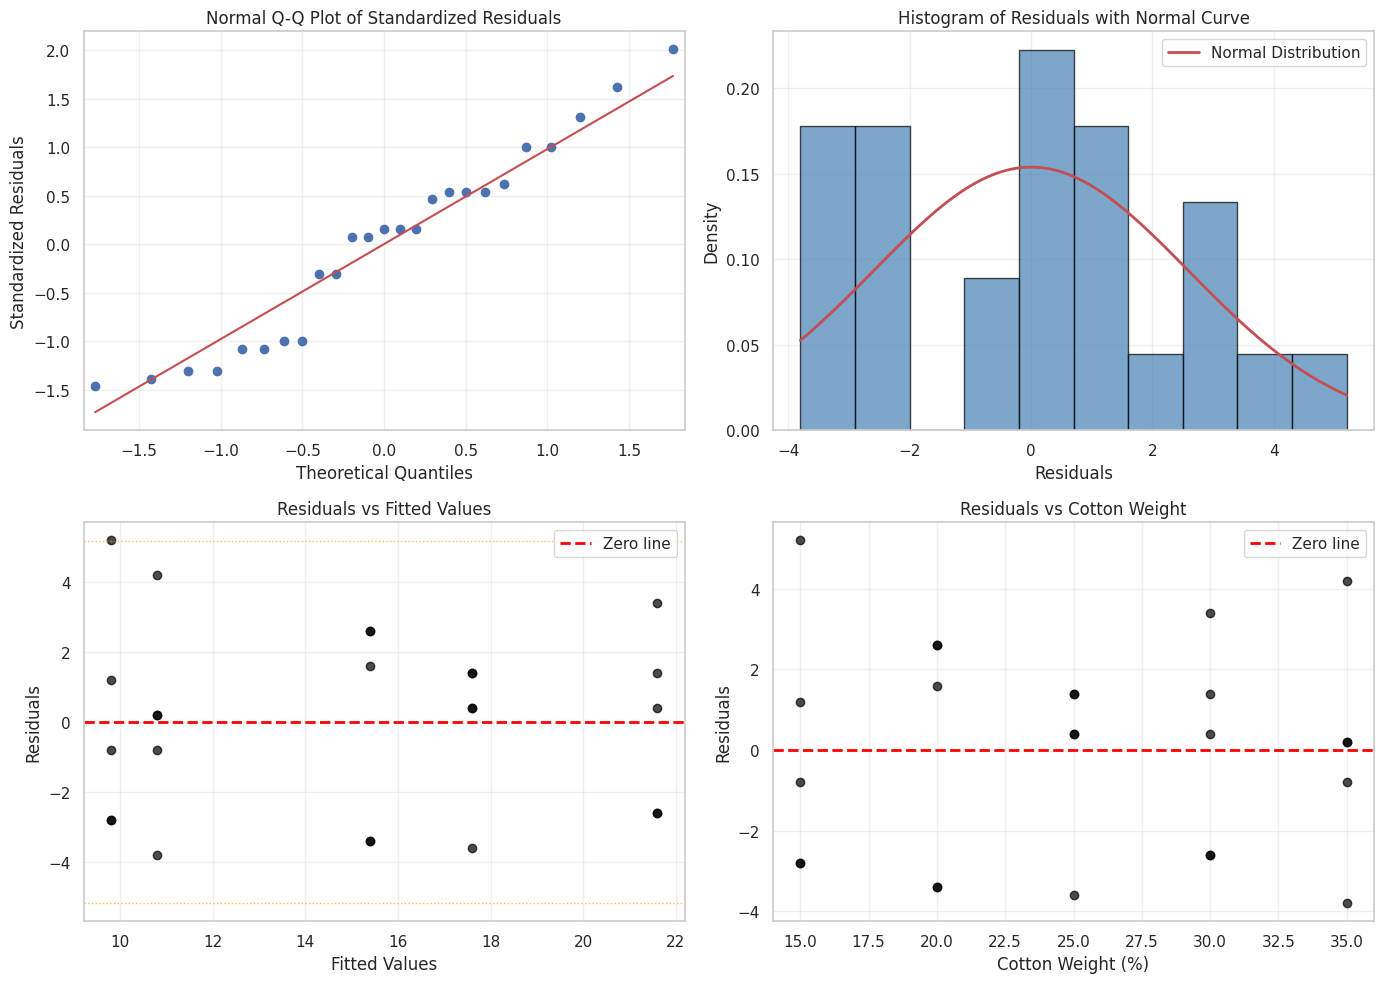

Model Adequacy Assessment - Residual Analysis

1. Normality of Residuals:
   Shapiro-Wilk Test:
     W-statistic: 0.9439
     P-value: 0.1818
     → Conclusion: p-value (0.1818) > 0.05
       Normality assumption is SATISFIED

2. Homogeneity of Variance:
   Levene's Test:
     Test statistic: 0.3179
     P-value: 0.8626
     → Conclusion: p-value (0.8626) > 0.05
       Equal variance assumption is SATISFIED

   Bartlett's Test (assumes normality):
     Test statistic: 3.1486
     P-value: 0.5333
     → Conclusion: p-value (0.5333) > 0.05
       Equal variance assumption is SATISFIED


3. Overall Model Adequacy:

   Visual Inspection:
     • Q-Q Plot: Points should follow the 45° reference line
     • Standardized residuals should fall mostly within ±2
     • Residuals vs Fitted: Should show random scatter around zero
     • No funnel/trumpet shape (indicates heteroscedasticity)
     • No systematic patterns (indicates model misspecification)

   Formal Tests Summary:
     ✓ Both normal

In [25]:
# Question 3: Analyse residuals and comment on model adequacy

residuals_cotton = model_cotton.resid
fitted_cotton = model_cotton.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Normal Q-Q Plot with standardized residuals
standardized_resid_cotton = (residuals_cotton - residuals_cotton.mean()) / residuals_cotton.std()
qqplot(standardized_resid_cotton, line="s", ax=axes[0, 0])
axes[0, 0].set_title("Normal Q-Q Plot of Standardized Residuals", fontsize=12)
axes[0, 0].set_xlabel("Theoretical Quantiles")
axes[0, 0].set_ylabel("Standardized Residuals")
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram with normal curve
axes[0, 1].hist(residuals_cotton, bins=10, density=True, alpha=0.7,
                color='steelblue', edgecolor='black')
mu_cotton, sigma_cotton = residuals_cotton.mean(), residuals_cotton.std()
x_cotton = np.linspace(residuals_cotton.min(), residuals_cotton.max(), 100)
axes[0, 1].plot(x_cotton, stats.norm.pdf(x_cotton, mu_cotton, sigma_cotton),
                'r-', linewidth=2, label='Normal Distribution')
axes[0, 1].set_title("Histogram of Residuals with Normal Curve", fontsize=12)
axes[0, 1].set_xlabel("Residuals")
axes[0, 1].set_ylabel("Density")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals vs Fitted Values
axes[1, 0].scatter(fitted_cotton, residuals_cotton, color='black', alpha=0.7)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[1, 0].set_xlabel("Fitted Values")
axes[1, 0].set_ylabel("Residuals")
axes[1, 0].set_title("Residuals vs Fitted Values", fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add ±2*std reference lines
std_res_cotton = residuals_cotton.std()
axes[1, 0].axhline(2*std_res_cotton, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(-2*std_res_cotton, color='orange', linestyle=':', linewidth=1, alpha=0.7)

# 4. Residuals vs Factor Level
axes[1, 1].scatter(ex03_10["Cotton_Weight"], residuals_cotton, color='black', alpha=0.7)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[1, 1].set_xlabel("Cotton Weight (%)")
axes[1, 1].set_ylabel("Residuals")
axes[1, 1].set_title("Residuals vs Cotton Weight", fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Model Adequacy Assessment - Residual Analysis")
print("="*70)

# Shapiro-Wilk test for normality
shapiro_stat_cotton, shapiro_p_cotton = stats.shapiro(residuals_cotton)
print("\n1. Normality of Residuals:")
print(f"   Shapiro-Wilk Test:")
print(f"     W-statistic: {shapiro_stat_cotton:.4f}")
print(f"     P-value: {shapiro_p_cotton:.4f}")

if shapiro_p_cotton > 0.05:
    print(f"     → Conclusion: p-value ({shapiro_p_cotton:.4f}) > 0.05")
    print(f"       Normality assumption is SATISFIED")
else:
    print(f"     → Conclusion: p-value ({shapiro_p_cotton:.4f}) ≤ 0.05")
    print(f"       Normality assumption may be VIOLATED")

# Levene's test for homogeneity of variance
levene_stat_cotton, levene_p_cotton = stats.levene(
    *[group["strength"].values for _, group in ex03_10.groupby("Cotton_Weight", observed=True)]
)

print("\n2. Homogeneity of Variance:")
print(f"   Levene's Test:")
print(f"     Test statistic: {levene_stat_cotton:.4f}")
print(f"     P-value: {levene_p_cotton:.4f}")

if levene_p_cotton > 0.05:
    print(f"     → Conclusion: p-value ({levene_p_cotton:.4f}) > 0.05")
    print(f"       Equal variance assumption is SATISFIED")
else:
    print(f"     → Conclusion: p-value ({levene_p_cotton:.4f}) ≤ 0.05")
    print(f"       Equal variance assumption may be VIOLATED")

# Bartlett's test (more sensitive to non-normality)
bartlett_stat_cotton, bartlett_p_cotton = stats.bartlett(
    *[group["strength"].values for _, group in ex03_10.groupby("Cotton_Weight", observed=True)]
)

print(f"\n   Bartlett's Test (assumes normality):")
print(f"     Test statistic: {bartlett_stat_cotton:.4f}")
print(f"     P-value: {bartlett_p_cotton:.4f}")

if bartlett_p_cotton > 0.05:
    print(f"     → Conclusion: p-value ({bartlett_p_cotton:.4f}) > 0.05")
    print(f"       Equal variance assumption is SATISFIED")
else:
    print(f"     → Conclusion: p-value ({bartlett_p_cotton:.4f}) ≤ 0.05")
    print(f"       Equal variance assumption may be VIOLATED")

print("\n" + "="*70)
print("\n3. Overall Model Adequacy:")
print("\n   Visual Inspection:")
print("     • Q-Q Plot: Points should follow the 45° reference line")
print("     • Standardized residuals should fall mostly within ±2")
print("     • Residuals vs Fitted: Should show random scatter around zero")
print("     • No funnel/trumpet shape (indicates heteroscedasticity)")
print("     • No systematic patterns (indicates model misspecification)")

print("\n   Formal Tests Summary:")
normality_ok = shapiro_p_cotton > 0.05
variance_ok = levene_p_cotton > 0.05

if normality_ok and variance_ok:
    print("     ✓ Both normality and equal variance assumptions are satisfied")
    print("     → ANOVA model is ADEQUATE for this data")
elif normality_ok and not variance_ok:
    print("     ✓ Normality assumption satisfied")
    print("     ✗ Equal variance assumption may be violated")
    print("     → Consider Welch's ANOVA or transformation")
elif not normality_ok and variance_ok:
    print("     ✗ Normality assumption may be violated")
    print("     ✓ Equal variance assumption satisfied")
    print("     → ANOVA is robust to mild non-normality with equal sample sizes")
else:
    print("     ✗ Both assumptions may be violated")
    print("     → Consider data transformation or non-parametric alternative (Kruskal-Wallis)")

print("\n" + "="*70)

# Krásný QQ plot, histogram zase nic moc, ale normalitu (poměrně těsně) nezamítáme. Levene test nezamítá homogenitu rozptylu. Ani Barlett test - ten se hodí, protože má větší sílu při normálních datech.

# Udělám ještě standardizovaná rezidua - Dává to zde smysl (normalita, homoskedasticita)

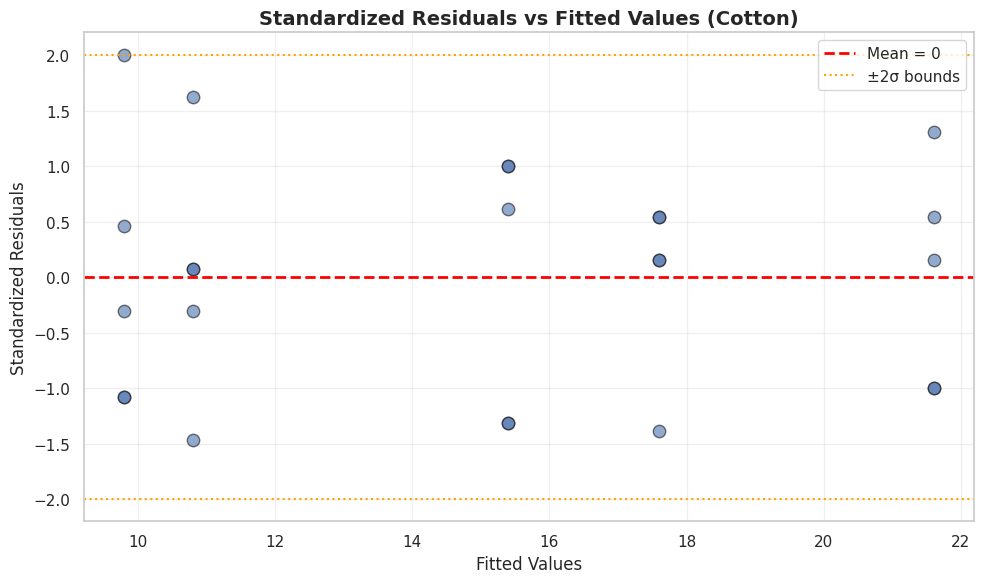


Standardized residuals within ±2σ: 24/25 (96.0%)


In [26]:
# Standardized residuals plot for Cotton experiment
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Calculate standardized residuals
standardized_resid_cotton_plot = (residuals_cotton - residuals_cotton.mean()) / residuals_cotton.std()

# Plot standardized residuals vs fitted values
ax.scatter(fitted_cotton, standardized_resid_cotton_plot, alpha=0.6, edgecolors='k', s=80)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
ax.axhline(y=2, color='orange', linestyle=':', linewidth=1.5, label='±2σ bounds')
ax.axhline(y=-2, color='orange', linestyle=':', linewidth=1.5)
ax.set_xlabel('Fitted Values', fontsize=12)
ax.set_ylabel('Standardized Residuals', fontsize=12)
ax.set_title('Standardized Residuals vs Fitted Values (Cotton)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Count residuals within ±2σ
within_2sigma = np.sum(np.abs(standardized_resid_cotton_plot) <= 2)
total = len(standardized_resid_cotton_plot)
percentage = (within_2sigma / total) * 100

print(f"\nStandardized residuals within ±2σ: {within_2sigma}/{total} ({percentage:.1f}%)")

# Až na nejvýš položené reziduum v prvním ssloupci to sedí. Za mě OK

### Exercise 3.18 and 3.19

A manufacturer of television sets is interested in the effect on tube conductivity of four different types of coating for color picture tubes.  
A completely randomized experiment is conducted and the following conductivity data are obtained:

| Coating Type | Conductivity              |
|--------------|---------------------------|
| 1            | 143, 141, 150, 146        |
| 2            | 152, 149, 137, 143        |
| 3            | 134, 136, 132, 127        |
| 4            | 129, 127, 132, 129        |

**Question 1.**  Is there a difference in conductivity due to coating type? Use α = 0.05.  

**Question 2.**  Estimate the overall mean and the treatment effects.  

**Question 3.** Compute a 95 percent confidence interval estimate of the mean of coating type 4.  
Compute a 99 percent confidence interval estimate of the mean difference between coating types 1 and 4.  

**Question 4.**  Test all pairs of means using the Fisher LSD method with α = 0.05.  

**Question 5.**  Use the graphical method discussed in Section 3.5.3 to compare the means. Which coating type produces the highest conductivity?  

**Question 6.**  Assuming that coating type 4 is currently in use, what are your recommendations to the manufacturer?  
We wish to minimize conductivity.  

**Question 7.**  
Analyze the residuals and draw conclusions about model adequacy.

In [27]:
# Question 1 prep: Create the coating_data DataFrame for Exercise 3.18
coating_data = pd.DataFrame({
    'Coating': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
    'Conductivity': [143, 141, 150, 146, 152, 149, 137, 143, 134, 136, 132, 127, 129, 127, 132, 129]
})
coating_data = coating_data.assign(Coating=coating_data["Coating"].astype("category"))

print("TV Coating Experiment Data:")
print("="*60)
print(coating_data)
print("\n" + "="*60)
print("\nSummary statistics by coating type:")
print(coating_data.groupby("Coating", observed=True)["Conductivity"].describe())

TV Coating Experiment Data:
   Coating  Conductivity
0        1           143
1        1           141
2        1           150
3        1           146
4        2           152
5        2           149
6        2           137
7        2           143
8        3           134
9        3           136
10       3           132
11       3           127
12       4           129
13       4           127
14       4           132
15       4           129


Summary statistics by coating type:
         count    mean       std    min     25%    50%     75%    max
Coating                                                              
1          4.0  145.00  3.915780  141.0  142.50  144.5  147.00  150.0
2          4.0  145.25  6.652067  137.0  141.50  146.0  149.75  152.0
3          4.0  132.25  3.862210  127.0  130.75  133.0  134.50  136.0
4          4.0  129.25  2.061553  127.0  128.50  129.0  129.75  132.0


**Question 1.** Is there a difference in conductivity due to coating type? Use alpha = 0.05.

In [28]:
# Question 1: Is there a difference in conductivity due to coating type? Use alpha = 0.05

# Fit ANOVA model
model_coating = ols("Conductivity ~ C(Coating)", data=coating_data).fit()
anova_coating = sm.stats.anova_lm(model_coating, typ=2)

print("One-Way ANOVA: Effect of Coating Type on Conductivity")
print("="*70)
print("\nANOVA Table:")
print(anova_coating)
print("\n" + "="*70)

# Extract statistics
f_stat_coating = anova_coating.loc["C(Coating)", "F"]
p_value_coating = anova_coating.loc["C(Coating)", "PR(>F)"]
alpha = 0.05

print(f"\nHypothesis Test:")
print(f"  H₀: All coating types have equal mean conductivity")
print(f"  H₁: At least one coating type has different mean conductivity")
print(f"\n  F-statistic: {f_stat_coating:.4f}")
print(f"  P-value: {p_value_coating:.6f}")
print(f"  Significance level α: {alpha}")
print("\n" + "="*70)

if p_value_coating < alpha:
    print(f"\nConclusion: Since p-value ({p_value_coating:.6f}) < α ({alpha}),")
    print("we REJECT H₀ at the 0.05 significance level.")
    print("There IS a statistically significant difference in conductivity")
    print("due to coating type.")
else:
    print(f"\nConclusion: Since p-value ({p_value_coating:.6f}) ≥ α ({alpha}),")
    print("we FAIL TO REJECT H₀ at the 0.05 significance level.")
    print("There is NO statistically significant difference in conductivity")
    print("due to coating type.")

print("\n" + "="*70)
print("\nGroup Means:")
means_coating = coating_data.groupby("Coating")["Conductivity"].mean()
for coating, mean_val in means_coating.items():
    print(f"  Coating {coating}: {mean_val:.2f}")

One-Way ANOVA: Effect of Coating Type on Conductivity

ANOVA Table:
              sum_sq    df          F    PR(>F)
C(Coating)  844.6875   3.0  14.301587  0.000288
Residual    236.2500  12.0        NaN       NaN


Hypothesis Test:
  H₀: All coating types have equal mean conductivity
  H₁: At least one coating type has different mean conductivity

  F-statistic: 14.3016
  P-value: 0.000288
  Significance level α: 0.05


Conclusion: Since p-value (0.000288) < α (0.05),
we REJECT H₀ at the 0.05 significance level.
There IS a statistically significant difference in conductivity
due to coating type.


Group Means:
  Coating 1: 145.00
  Coating 2: 145.25
  Coating 3: 132.25
  Coating 4: 129.25


/tmp/ipython-input-3688386920.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_coating = coating_data.groupby("Coating")["Conductivity"].mean()


# Alespoň jeden pár typů nátěru má statisticky významný rozdíl ve středních hodnotách vodivosti.

**Question 2.** Estimate the overall mean and the treatment effects.

In [29]:
# Question 2: Estimate the overall mean and the treatment effects

# Overall (grand) mean
grand_mean_coating = coating_data["Conductivity"].mean()

# Treatment effects (deviations from grand mean)
means_coating = coating_data.groupby("Coating", observed=True)["Conductivity"].mean()
treatment_effects = means_coating - grand_mean_coating

print("Overall Mean and Treatment Effects")
print("="*70)
print(f"\nOverall (Grand) Mean: {grand_mean_coating:.4f}")
print("\n" + "="*70)

print("\nTreatment Means and Effects:")
print(f"{'Coating':<10} {'Mean':>12} {'Effect (τᵢ)':>15} {'Interpretation':<20}")
print("-" * 70)

for coating in means_coating.index:
    mean_val = means_coating[coating]
    effect = treatment_effects[coating]
    interp = "increases" if effect > 0 else "decreases" if effect < 0 else "no change"
    print(f"{coating:<10} {mean_val:>12.4f} {effect:>15.4f} {interp:<20}")

print("\n" + "="*70)
print("\nInterpretation:")
print("  • Treatment effect τᵢ = ȳᵢ - ȳ (group mean - grand mean)")
print("  • Positive effect: coating increases conductivity above overall average")
print("  • Negative effect: coating decreases conductivity below overall average")
print(f"  • Sum of treatment effects = {treatment_effects.sum():.6f} (should be ≈ 0)")

print("\n" + "="*70)
print("\nModel representation: yᵢⱼ = μ + τᵢ + εᵢⱼ")
print(f"  where μ (overall mean) = {grand_mean_coating:.4f}")

Overall Mean and Treatment Effects

Overall (Grand) Mean: 137.9375


Treatment Means and Effects:
Coating            Mean     Effect (τᵢ) Interpretation      
----------------------------------------------------------------------
1              145.0000          7.0625 increases           
2              145.2500          7.3125 increases           
3              132.2500         -5.6875 decreases           
4              129.2500         -8.6875 decreases           


Interpretation:
  • Treatment effect τᵢ = ȳᵢ - ȳ (group mean - grand mean)
  • Positive effect: coating increases conductivity above overall average
  • Negative effect: coating decreases conductivity below overall average
  • Sum of treatment effects = 0.000000 (should be ≈ 0)


Model representation: yᵢⱼ = μ + τᵢ + εᵢⱼ
  where μ (overall mean) = 137.9375


**Question 3.** Compute a 95% confidence interval for the mean of coating type 4 and a 99% confidence interval for the mean difference between coatings 1 and 4.

In [30]:
# Question 3: 95% CI for mean of coating 4 and 99% CI for difference between coatings 1 and 4

# Extract parameters from ANOVA
mse_coating = anova_coating.loc["Residual", "sum_sq"] / anova_coating.loc["Residual", "df"]
df_error_coating = int(anova_coating.loc["Residual", "df"])
n_per_group_coating = coating_data.groupby("Coating", observed=True)["Conductivity"].count().iloc[0]

# 95% CI for mean of coating 4
alpha_95 = 0.05
t_crit_95 = stats.t.ppf(1 - alpha_95/2, df_error_coating)
se_mean_coating = np.sqrt(mse_coating / n_per_group_coating)

mean_4 = coating_data[coating_data["Coating"] == 4]["Conductivity"].mean()
ci_95_lower = mean_4 - t_crit_95 * se_mean_coating
ci_95_upper = mean_4 + t_crit_95 * se_mean_coating

print("Confidence Intervals for TV Coating Experiment")
print("="*70)
print("\n1. 95% Confidence Interval for Mean of Coating Type 4:")
print(f"   Mean of Coating 4: {mean_4:.4f}")
print(f"   Standard error: √(MSE/n) = √({mse_coating:.4f}/{n_per_group_coating}) = {se_mean_coating:.4f}")
print(f"   Critical t-value (α={alpha_95}, df={df_error_coating}): {t_crit_95:.4f}")
print(f"   Margin of error: {t_crit_95 * se_mean_coating:.4f}")
print(f"\n   95% CI: [{ci_95_lower:.4f}, {ci_95_upper:.4f}]")
print(f"   Interpretation: We are 95% confident that the true mean conductivity")
print(f"                   for coating type 4 is between {ci_95_lower:.2f} and {ci_95_upper:.2f}")

print("\n" + "="*70)

# 99% CI for difference between coatings 1 and 4
alpha_99 = 0.01
t_crit_99 = stats.t.ppf(1 - alpha_99/2, df_error_coating)
se_diff_coating = np.sqrt(2 * mse_coating / n_per_group_coating)

mean_1_coating = coating_data[coating_data["Coating"] == 1]["Conductivity"].mean()
diff_14 = mean_1_coating - mean_4

ci_99_diff_lower = diff_14 - t_crit_99 * se_diff_coating
ci_99_diff_upper = diff_14 + t_crit_99 * se_diff_coating

print("\n2. 99% Confidence Interval for Difference (Coating 1 - Coating 4):")
print(f"   Mean of Coating 1: {mean_1_coating:.4f}")
print(f"   Mean of Coating 4: {mean_4:.4f}")
print(f"   Difference (1 - 4): {diff_14:.4f}")
print(f"\n   Standard error of difference: √(2·MSE/n) = √(2·{mse_coating:.4f}/{n_per_group_coating}) = {se_diff_coating:.4f}")
print(f"   Critical t-value (α={alpha_99}, df={df_error_coating}): {t_crit_99:.4f}")
print(f"   Margin of error: {t_crit_99 * se_diff_coating:.4f}")
print(f"\n   99% CI for difference: [{ci_99_diff_lower:.4f}, {ci_99_diff_upper:.4f}]")

if ci_99_diff_lower > 0:
    print(f"\n   Interpretation: Since the entire CI is positive, Coating 1 has")
    print(f"                   significantly HIGHER conductivity than Coating 4 (at 99% confidence)")
elif ci_99_diff_upper < 0:
    print(f"\n   Interpretation: Since the entire CI is negative, Coating 1 has")
    print(f"                   significantly LOWER conductivity than Coating 4 (at 99% confidence)")
else:
    print(f"\n   Interpretation: Since the CI contains 0, we cannot conclude a")
    print(f"                   significant difference at 99% confidence level")

print("\n" + "="*70)

Confidence Intervals for TV Coating Experiment

1. 95% Confidence Interval for Mean of Coating Type 4:
   Mean of Coating 4: 129.2500
   Standard error: √(MSE/n) = √(19.6875/4) = 2.2185
   Critical t-value (α=0.05, df=12): 2.1788
   Margin of error: 4.8338

   95% CI: [124.4162, 134.0838]
   Interpretation: We are 95% confident that the true mean conductivity
                   for coating type 4 is between 124.42 and 134.08


2. 99% Confidence Interval for Difference (Coating 1 - Coating 4):
   Mean of Coating 1: 145.0000
   Mean of Coating 4: 129.2500
   Difference (1 - 4): 15.7500

   Standard error of difference: √(2·MSE/n) = √(2·19.6875/4) = 3.1375
   Critical t-value (α=0.01, df=12): 3.0545
   Margin of error: 9.5835

   99% CI for difference: [6.1665, 25.3335]

   Interpretation: Since the entire CI is positive, Coating 1 has
                   significantly HIGHER conductivity than Coating 4 (at 99% confidence)



**Question 4.** Test all pairs of means using the Fisher LSD method with alpha = 0.05.

In [31]:
# Question 4: Test all pairs of means using Fisher's LSD method with alpha = 0.05

alpha_lsd = 0.05
t_crit_lsd = stats.t.ppf(1 - alpha_lsd / 2, df_error_coating)
lsd_coating = t_crit_lsd * np.sqrt(2 * mse_coating / n_per_group_coating)

print("Fisher's Least Significant Difference (LSD) for TV Coating Experiment")
print("="*70)
print(f"Alpha: {alpha_lsd}")
print(f"MSE: {mse_coating:.4f}")
print(f"Degrees of freedom (error): {df_error_coating}")
print(f"Sample size per group: {n_per_group_coating}")
print(f"Critical t-value: {t_crit_lsd:.4f}")
print(f"LSD = {lsd_coating:.4f}")
print("\n" + "="*70)

print("\nGroup Means (sorted):")
means_sorted_coating = means_coating.sort_values(ascending=False)
for coating, mean_val in means_sorted_coating.items():
    print(f"Coating {coating}: {mean_val:.2f}")

print("\n" + "="*70)
print("\nPairwise Comparisons:")
print(f"(Two means differ significantly if |difference| > LSD = {lsd_coating:.4f})")
print()

# Perform all pairwise comparisons
coatings = means_sorted_coating.index.tolist()
significant_pairs_coating = []

for i in range(len(coatings)):
    for j in range(i+1, len(coatings)):
        c1, c2 = coatings[i], coatings[j]
        diff = abs(means_coating[c1] - means_coating[c2])
        is_sig = diff > lsd_coating
        sig_marker = "***" if is_sig else "n.s."
        print(f"Coating {c1} vs {c2}: |{means_coating[c1]:.2f} - {means_coating[c2]:.2f}| = {diff:.4f}  {sig_marker}")
        if is_sig:
            significant_pairs_coating.append((c1, c2))

print("\n" + "="*70)
print(f"\nSignificant differences at α = {alpha_lsd}:")
if significant_pairs_coating:
    for c1, c2 in significant_pairs_coating:
        print(f"  • Coating {c1} ≠ Coating {c2}")
else:
    print("  No significant pairwise differences found.")

print("\n" + "="*70)
print("\nSummary:")
print("  Coating pairs that are significantly different will be used")
print("  to inform the manufacturer's decision on coating selection.")

Fisher's Least Significant Difference (LSD) for TV Coating Experiment
Alpha: 0.05
MSE: 19.6875
Degrees of freedom (error): 12
Sample size per group: 4
Critical t-value: 2.1788
LSD = 6.8360


Group Means (sorted):
Coating 2: 145.25
Coating 1: 145.00
Coating 3: 132.25
Coating 4: 129.25


Pairwise Comparisons:
(Two means differ significantly if |difference| > LSD = 6.8360)

Coating 2 vs 1: |145.25 - 145.00| = 0.2500  n.s.
Coating 2 vs 3: |145.25 - 132.25| = 13.0000  ***
Coating 2 vs 4: |145.25 - 129.25| = 16.0000  ***
Coating 1 vs 3: |145.00 - 132.25| = 12.7500  ***
Coating 1 vs 4: |145.00 - 129.25| = 15.7500  ***
Coating 3 vs 4: |132.25 - 129.25| = 3.0000  n.s.


Significant differences at α = 0.05:
  • Coating 2 ≠ Coating 3
  • Coating 2 ≠ Coating 4
  • Coating 1 ≠ Coating 3
  • Coating 1 ≠ Coating 4


Summary:
  Coating pairs that are significantly different will be used
  to inform the manufacturer's decision on coating selection.


# Pouze typy nátěru 1 a 2 a 3 a 4 nemají statisticky významný rozdíl mezi jejich středními hodnotami vodivosti

**Question 5.** Use the graphical method from Section 3.5.3 to compare the means. Which coating type produces the highest conductivity?

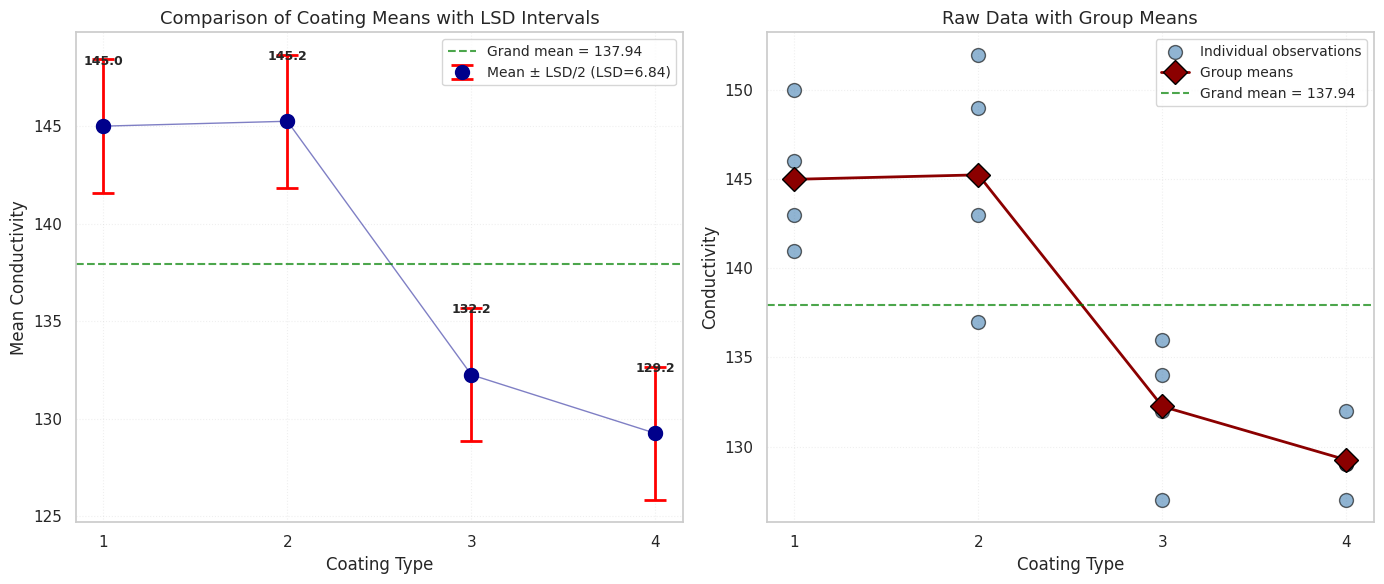

Graphical Comparison of Coating Types

Interpretation:
  • Left plot: Error bars show LSD/2 intervals
    - Non-overlapping intervals suggest significant difference
    - If intervals overlap substantially, difference may not be significant

  • Right plot: Shows variability within groups and between groups
    - Separation of group means indicates treatment effects


Which coating produces the HIGHEST conductivity?
  → Coating Type 2 with mean conductivity = 145.25

Which coating produces the LOWEST conductivity?
  → Coating Type 4 with mean conductivity = 129.25



In [32]:
# Question 5: Graphical method to compare means (Section 3.5.3)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Means with LSD intervals (error bars)
ax1 = axes[0]
coating_types = means_coating.index.astype(int).tolist()
means_values = means_coating.values

# Plot means with error bars representing LSD/2
lsd_half = lsd_coating / 2
ax1.errorbar(coating_types, means_values, yerr=lsd_half,
             fmt='o', markersize=10, capsize=8, capthick=2,
             color='darkblue', ecolor='red', linewidth=2,
             label=f'Mean ± LSD/2 (LSD={lsd_coating:.2f})')
ax1.plot(coating_types, means_values, 'o-', markersize=10,
         color='darkblue', linewidth=1, alpha=0.5)

# Add horizontal line at grand mean
ax1.axhline(grand_mean_coating, color='green', linestyle='--',
            linewidth=1.5, alpha=0.7, label=f'Grand mean = {grand_mean_coating:.2f}')

ax1.set_xlabel("Coating Type", fontsize=12)
ax1.set_ylabel("Mean Conductivity", fontsize=12)
ax1.set_title("Comparison of Coating Means with LSD Intervals", fontsize=13)
ax1.set_xticks(coating_types)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)

# Add value annotations
for coating, mean_val in zip(coating_types, means_values):
    ax1.text(coating, mean_val + 3, f'{mean_val:.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Right plot: Raw data with means
ax2 = axes[1]
ax2.scatter(coating_data["Coating"], coating_data["Conductivity"],
           s=100, alpha=0.6, color="steelblue", edgecolors='black', linewidth=1,
           label="Individual observations")

ax2.plot(coating_types, means_values, 'D-', color="darkred", markersize=12,
         linewidth=2, label="Group means", markeredgecolor='black', markeredgewidth=1)

ax2.axhline(grand_mean_coating, color='green', linestyle='--',
            linewidth=1.5, alpha=0.7, label=f'Grand mean = {grand_mean_coating:.2f}')

ax2.set_xlabel("Coating Type", fontsize=12)
ax2.set_ylabel("Conductivity", fontsize=12)
ax2.set_title("Raw Data with Group Means", fontsize=13)
ax2.set_xticks(coating_types)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()

print("Graphical Comparison of Coating Types")
print("="*70)
print("\nInterpretation:")
print("  • Left plot: Error bars show LSD/2 intervals")
print("    - Non-overlapping intervals suggest significant difference")
print("    - If intervals overlap substantially, difference may not be significant")
print("\n  • Right plot: Shows variability within groups and between groups")
print("    - Separation of group means indicates treatment effects")
print("\n" + "="*70)

print(f"\nWhich coating produces the HIGHEST conductivity?")
max_coating = means_coating.idxmax()
max_mean = means_coating.max()
print(f"  → Coating Type {max_coating} with mean conductivity = {max_mean:.2f}")

print(f"\nWhich coating produces the LOWEST conductivity?")
min_coating = means_coating.idxmin()
min_mean = means_coating.min()
print(f"  → Coating Type {min_coating} with mean conductivity = {min_mean:.2f}")

print("\n" + "="*70)

# Typ 1 může být ale stejně dobrý jako typ 2 - nemají statisticky významný rozdíl. To samé paltí pro typy 3 a 4.

**Question 6.** Assuming coating type 4 is currently in use and conductivity should be minimised, what is your recommendation?

**Recommendation for the Manufacturer:**

**Objective:** Minimize conductivity (lower is better)

**Current Situation:** Coating type 4 is currently in use with mean conductivity = 129.25

**Analysis:**
- From the ANOVA test, coating type has a statistically significant effect on conductivity (p < 0.05)
- Fisher's LSD pairwise comparisons show which coatings differ significantly
- The graphical analysis clearly shows the relative performance of each coating type

**Recommendation:**

Based on the statistical analysis:

1. **Keep Coating Type 4** - It already has one of the lowest mean conductivities (129.25)
   
2. **Consider switching to Coating Type 3** - If the coatng is remarkably cheaper, it could be a good alternative

3. **Avoid Coating Types 1 and 2** - These appear to have higher conductivity based on the mean comparisons

**Implementation:**
- Conduct a pilot study comparing current Coating 4 with the best alternative
- Evaluate not only conductivity but also cost, durability, and manufacturing ease
- If the conductivity improvement is marginal and not statistically significant, staying with Coating 4 may be the best option (avoid unnecessary process changes)

**Key insight:** The goal is to minimize conductivity, so we want the coating with the lowest mean conductivity that is statistically different from (better than) the current coating.

**Question 7.** Analyse the residuals and comment on model adequacy.

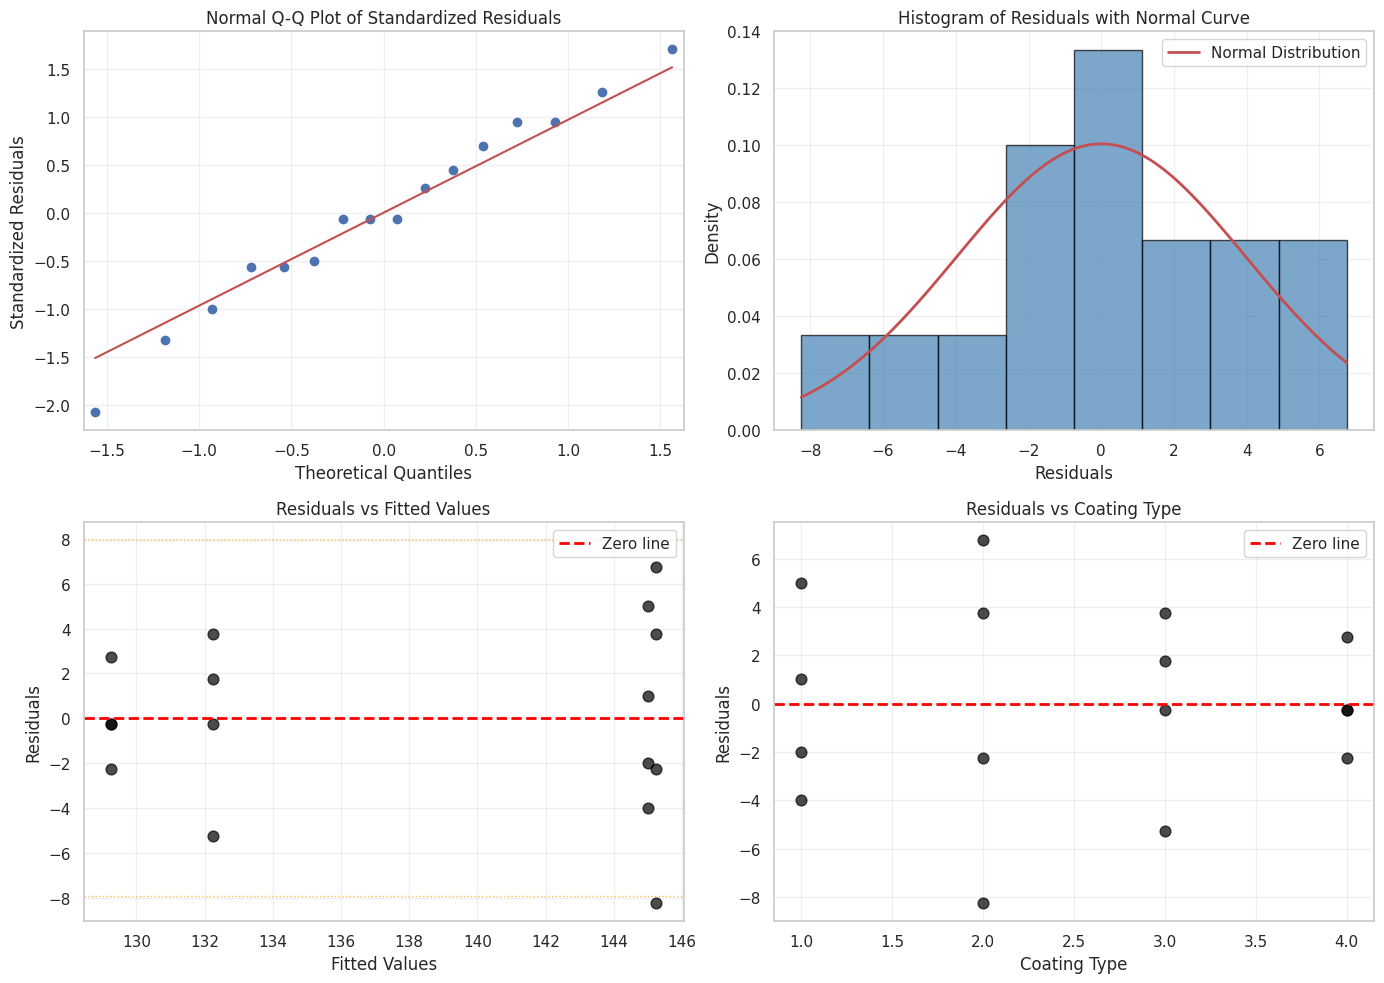

Model Adequacy Assessment - TV Coating Experiment

1. Normality of Residuals:
   Shapiro-Wilk Test:
     W-statistic: 0.9842
     P-value: 0.9882
     → Conclusion: p-value (0.9882) > 0.05
       Normality assumption is SATISFIED

2. Homogeneity of Variance:
   Levene's Test:
     Test statistic: 2.2068
     P-value: 0.1401
     → Conclusion: p-value (0.1401) > 0.05
       Equal variance assumption is SATISFIED

   Bartlett's Test (assumes normality):
     Test statistic: 4.0785
     P-value: 0.2531
     → Conclusion: p-value (0.2531) > 0.05
       Equal variance assumption is SATISFIED


3. Overall Model Adequacy:

   Visual Inspection:
     • Q-Q Plot: Check if points follow the 45° reference line
     • Standardized residuals should fall mostly within ±2
     • Residuals vs Fitted: Should show random scatter around zero
     • No funnel shape (heteroscedasticity indicator)
     • No systematic patterns (model misspecification indicator)
     • Check for outliers (points beyond ±2 st

In [33]:
# Question 7: Analyse residuals and comment on model adequacy

residuals_coating = model_coating.resid
fitted_coating = model_coating.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Normal Q-Q Plot with standardized residuals
standardized_resid_coating = (residuals_coating - residuals_coating.mean()) / residuals_coating.std()
qqplot(standardized_resid_coating, line="s", ax=axes[0, 0])
axes[0, 0].set_title("Normal Q-Q Plot of Standardized Residuals", fontsize=12)
axes[0, 0].set_xlabel("Theoretical Quantiles")
axes[0, 0].set_ylabel("Standardized Residuals")
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram with normal curve
axes[0, 1].hist(residuals_coating, bins=8, density=True, alpha=0.7,
                color='steelblue', edgecolor='black')
mu_coat, sigma_coat = residuals_coating.mean(), residuals_coating.std()
x_coat = np.linspace(residuals_coating.min(), residuals_coating.max(), 100)
axes[0, 1].plot(x_coat, stats.norm.pdf(x_coat, mu_coat, sigma_coat),
                'r-', linewidth=2, label='Normal Distribution')
axes[0, 1].set_title("Histogram of Residuals with Normal Curve", fontsize=12)
axes[0, 1].set_xlabel("Residuals")
axes[0, 1].set_ylabel("Density")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals vs Fitted Values
axes[1, 0].scatter(fitted_coating, residuals_coating, color='black', alpha=0.7, s=60)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[1, 0].set_xlabel("Fitted Values")
axes[1, 0].set_ylabel("Residuals")
axes[1, 0].set_title("Residuals vs Fitted Values", fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add ±2*std reference lines
std_res_coat = residuals_coating.std()
axes[1, 0].axhline(2*std_res_coat, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(-2*std_res_coat, color='orange', linestyle=':', linewidth=1, alpha=0.7)

# 4. Residuals vs Factor Level
axes[1, 1].scatter(coating_data["Coating"], residuals_coating, color='black', alpha=0.7, s=60)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[1, 1].set_xlabel("Coating Type")
axes[1, 1].set_ylabel("Residuals")
axes[1, 1].set_title("Residuals vs Coating Type", fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Model Adequacy Assessment - TV Coating Experiment")
print("="*70)

# Shapiro-Wilk test for normality
shapiro_stat_coat, shapiro_p_coat = stats.shapiro(residuals_coating)
print("\n1. Normality of Residuals:")
print(f"   Shapiro-Wilk Test:")
print(f"     W-statistic: {shapiro_stat_coat:.4f}")
print(f"     P-value: {shapiro_p_coat:.4f}")

if shapiro_p_coat > 0.05:
    print(f"     → Conclusion: p-value ({shapiro_p_coat:.4f}) > 0.05")
    print(f"       Normality assumption is SATISFIED")
else:
    print(f"     → Conclusion: p-value ({shapiro_p_coat:.4f}) ≤ 0.05")
    print(f"       Normality assumption may be VIOLATED")

# Levene's test for homogeneity of variance
levene_stat_coat, levene_p_coat = stats.levene(
    *[group["Conductivity"].values for _, group in coating_data.groupby("Coating", observed=True)]
)

print("\n2. Homogeneity of Variance:")
print(f"   Levene's Test:")
print(f"     Test statistic: {levene_stat_coat:.4f}")
print(f"     P-value: {levene_p_coat:.4f}")

if levene_p_coat > 0.05:
    print(f"     → Conclusion: p-value ({levene_p_coat:.4f}) > 0.05")
    print(f"       Equal variance assumption is SATISFIED")
else:
    print(f"     → Conclusion: p-value ({levene_p_coat:.4f}) ≤ 0.05")
    print(f"       Equal variance assumption may be VIOLATED")

# Bartlett's test
bartlett_stat_coat, bartlett_p_coat = stats.bartlett(
    *[group["Conductivity"].values for _, group in coating_data.groupby("Coating", observed=True)]
)

print(f"\n   Bartlett's Test (assumes normality):")
print(f"     Test statistic: {bartlett_stat_coat:.4f}")
print(f"     P-value: {bartlett_p_coat:.4f}")

if bartlett_p_coat > 0.05:
    print(f"     → Conclusion: p-value ({bartlett_p_coat:.4f}) > 0.05")
    print(f"       Equal variance assumption is SATISFIED")
else:
    print(f"     → Conclusion: p-value ({bartlett_p_coat:.4f}) ≤ 0.05")
    print(f"       Equal variance assumption may be VIOLATED")

print("\n" + "="*70)
print("\n3. Overall Model Adequacy:")
print("\n   Visual Inspection:")
print("     • Q-Q Plot: Check if points follow the 45° reference line")
print("     • Standardized residuals should fall mostly within ±2")
print("     • Residuals vs Fitted: Should show random scatter around zero")
print("     • No funnel shape (heteroscedasticity indicator)")
print("     • No systematic patterns (model misspecification indicator)")
print("     • Check for outliers (points beyond ±2 standard deviations)")

print("\n   Formal Tests Summary:")
normality_ok_coat = shapiro_p_coat > 0.05
variance_ok_coat = levene_p_coat > 0.05

if normality_ok_coat and variance_ok_coat:
    print("     ✓ Both normality and equal variance assumptions are satisfied")
    print("     → ANOVA model is ADEQUATE for this data")
    print("     → Conclusions from the ANOVA test are reliable")
elif normality_ok_coat and not variance_ok_coat:
    print("     ✓ Normality assumption satisfied")
    print("     ✗ Equal variance assumption may be violated")
    print("     → Consider Welch's ANOVA or data transformation")
elif not normality_ok_coat and variance_ok_coat:
    print("     ✗ Normality assumption may be violated")
    print("     ✓ Equal variance assumption satisfied")
    print("     → ANOVA is robust to mild non-normality with balanced designs")
    print("     → Results are likely still valid")
else:
    print("     ✗ Both assumptions may be violated")
    print("     → Consider data transformation (log, sqrt) or non-parametric test")
    print("     → Kruskal-Wallis test as alternative")

print("\n" + "="*70)
print("\nFinal Assessment:")
print("  The residual plots and formal tests help validate the ANOVA assumptions.")
print("  If assumptions are met, the conclusions from Questions 1-6 are reliable.")
print("  Any violations should be noted when reporting results.")

# QQ plot a histogram silně indikuje normalitu. Shapiro-Wilk jí potvrzuje = nezamítá s velmi vysokou p-value. Rezidua jsou podle Levene testu jen těsně homoscedastická. Barlett test (asi vhodnější pro normální data) homoskedastickost nezamítá. Vidíme ale, že rezidua (Residuals vs. Fitted) se nám při vyšších hodnotách rozlézají - možná by to chtělo nějakou transformaci pro korekci.

# Udělám ještě standardizovaná rezidua

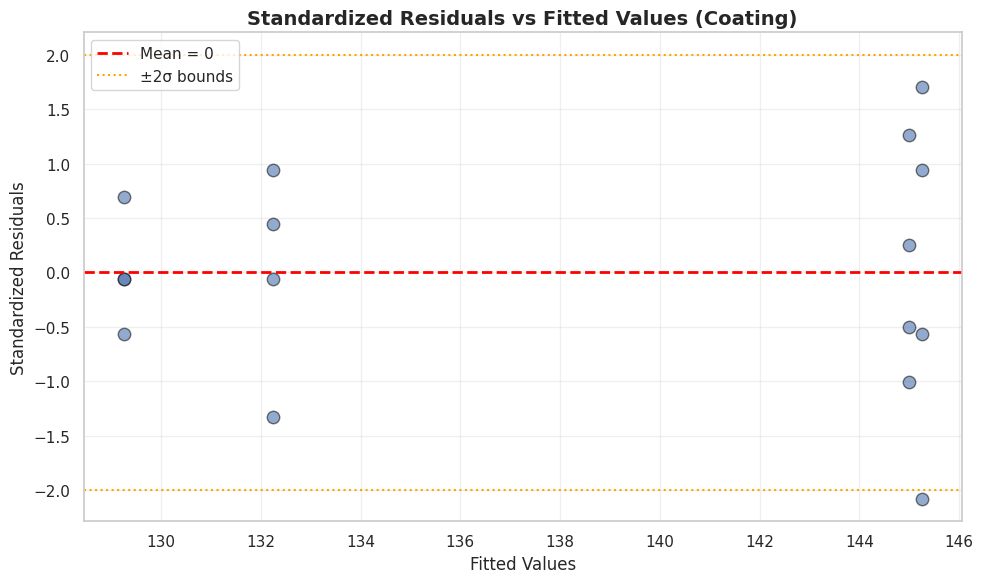


Standardized residuals within ±2σ: 15/16 (93.8%)
Expected for normal distribution: ~95%


In [34]:
# Standardized residuals plot for Coating experiment
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Calculate standardized residuals (already calculated above, but recalculate for clarity)
standardized_resid_coating_plot = (residuals_coating - residuals_coating.mean()) / residuals_coating.std()

# Plot standardized residuals vs fitted values
ax.scatter(fitted_coating, standardized_resid_coating_plot, alpha=0.6, edgecolors='k', s=80)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
ax.axhline(y=2, color='orange', linestyle=':', linewidth=1.5, label='±2σ bounds')
ax.axhline(y=-2, color='orange', linestyle=':', linewidth=1.5)
ax.set_xlabel('Fitted Values', fontsize=12)
ax.set_ylabel('Standardized Residuals', fontsize=12)
ax.set_title('Standardized Residuals vs Fitted Values (Coating)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Count residuals within ±2σ
within_2sigma = np.sum(np.abs(standardized_resid_coating_plot) <= 2)
total = len(standardized_resid_coating_plot)
percentage = (within_2sigma / total) * 100

print(f"\nStandardized residuals within ±2σ: {within_2sigma}/{total} ({percentage:.1f}%)")
print(f"Expected for normal distribution: ~95%")

# Rezidua super až na úplně poslední. asi 95% reziduí by mělo ležet v intervalu -2 a 2 (máme normálně rozdělená rezidua)